# ML Test Red Oaks Marketing Group: Modelos Predictivos de Clasificación Binaria de Clic sobre anuncio mediante técnicas de Aprendizaje Supervisado

Diego F. Osorio 

Machine Learning Engineer
MSc in Electronics and Computer Science (AI)

**Universidad de los Andes**

* Introducción
* Exploración
* ML Pipelines
* Evaluación
* Predicciones
* Conclusiones

# Librerias

In [2]:
# general
import numpy as np
import pandas as pd
import re
import os
import joblib
import pandas as pd
import random
import scipy.stats as stats
import pylab
import itertools

# funciones
from funciones.data_exploration import explore
from funciones.feature_cleaning import missing_data, outlier, rare_values
from funciones.feature_cleaning import missing_data as ms
from funciones.feature_cleaning import outlier as ot
from funciones.feature_cleaning import rare_values as ra
from funciones.feature_engineering import discretization as dc
from funciones.feature_engineering import discretization, encoding, transformation
from funciones.feature_selection import embedded_method, feature_shuffle, filter_method, hybrid


# visualización
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import warn
from pandas.plotting import scatter_matrix
plt.style.use('seaborn-colorblind')
#from data_exploration import explore


# preprocesamiento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import KBinsDiscretizer


# ML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# metricas de evaluacion
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, confusion_matrix 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error 
from sklearn.metrics import classification_report


# autoML H2O
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
# crear cluster de h2o
h2o.init(nthreads = 3, max_mem_size = 8)


# autoML TPOT
from tpot import TPOTClassifier


# ML pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel


from sklearn import set_config



C:\Users\Diego\AppData\Local\Temp\ipykernel_16516\2729423577.py:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,13 hours 50 mins
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_Diego_yty007
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


In [ ]:
rf_l = RandomForestClassifier(n_jobs=-1, verbose = 0, random_state=1, class_weight='balanced')
xgb_l = XGBClassifier(verbosity=0, random_state=1,  class_weight='balanced', validate_parameters=True, objective='multi:softprob', num_class=8, tree_method= 'gpu_hist', scale_pos_weight='balanced' )
lgb_l = LGBMClassifier(n_jobs=-1, random_state= 1, objective='multiclass', device = 'gpu', class_weight='balanced') # class_weight='balanced'
cat_l = CatBoostClassifier(task_type="GPU", random_state=1, verbose = 0)


In [294]:
# Matriz de Confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta')
    plt.xlabel('Predicción')

In [295]:

seed = np.random.seed(1)
seed

# Generar Base de datos

In [296]:
# Number of samples
n_samples = 1000

# Generate the sample data
data = {
    'copy': [random.choice(["50% off!", "Buy now!", "Limited offer!", "Best in town!", "Hurry up!", "Don't miss out!"]) for _ in range(n_samples)],
    'audience': [random.choice(["teens", "adults", "parents", "students", "elderly"]) for _ in range(n_samples)],
    'keywords': [random.choice(["sale", "discount", "offer", "limited", "exclusive", "bestseller"]) for _ in range(n_samples)],
    'time_of_day': [random.choice([i for i in range(24)]) for _ in range(n_samples)],  # 0 to 23 representing hours
    'clicked': [random.choice([0, 1]) for _ in range(n_samples)]
}

# Convert dictionary to DataFrame
df = pd.DataFrame(data)

# Add some intentional patterns
for i in range(n_samples):
    if df.at[i, 'audience'] == 'elderly' and df.at[i, 'copy'] == "Hurry up!":
        df.at[i, 'clicked'] = 0  # Elderly audience might not respond well to a 'Hurry up!' message
    
    if df.at[i, 'time_of_day'] >= 6 and df.at[i, 'time_of_day'] <= 11 and df.at[i, 'keywords'] == 'sale':
        df.at[i, 'clicked'] = 1  # More people might click on 'sale' keyword ads in the morning hours

# Save the dataset to a CSV file
df.to_csv("data/ad_data.csv", index=False)

df

,copy,audience,keywords,time_of_day,clicked
0,Hurry up!,teens,bestseller,6,1
1,50% off!,teens,offer,6,1
2,Buy now!,students,exclusive,13,1
3,Buy now!,adults,discount,23,1
4,Buy now!,adults,bestseller,8,1
...,...,...,...,...,...
995,50% off!,parents,sale,1,0
996,Buy now!,students,sale,9,1
997,Hurry up!,elderly,offer,5,0
998,Buy now!,students,sale,13,1


# Modelo Base: XGBoost default

In [297]:
### CORRER SOLO SI SE QUIERE VER EL ERROR

""" 
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

data = pd.read_csv("data/ad_data.csv")

X = data.drop('clicked', axis=1)
y = data['clicked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}") 

"""

' \nimport pandas as pd\nfrom xgboost import XGBClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score, roc_auc_score\n\ndata = pd.read_csv("data/ad_data.csv")\n\nX = data.drop(\'clicked\', axis=1)\ny = data[\'clicked\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\nmodel = XGBClassifier()\nmodel.fit(X_train, y_train)\n\ny_pred = model.predict(X_test)\n\nprint(f"Accuracy: {accuracy_score(y_test, y_pred)}") \n\n'

# Explicación del Error

El error en el código se debe a que se está intentado entrenar el modelo de ML XGBoost con variables (columnas) categóricas que todavía no se han preprocesado (codificado), por lo que el modelo no puede entrenarse correctamente. A continuación, se presenta el código corregido

In [298]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

data = pd.read_csv("data/ad_data.csv")

X = data.drop('clicked', axis=1)
y = data['clicked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# codificar variables en datos de entrenamiento y prueba
# codificación one-hot [0-1] para poder procesar las variables categóricas
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

### AGREGADO: métrica de evaluación recall
print(f"Recall: {recall_score(y_test, y_pred)}")



Accuracy: 0.57
Recall: 0.5757575757575758


La precisión (accuracy) que es una métrica de evaluación en relación al error a partir de la siguiente formula nos dice que el modelo XGBoost Base tiene 0.515 de precisión, es decir el error es aproximadamente 0.49.


$Accuracy = (TP+TN)/(TOT)$

Mediante este Jupyter Notebook se aplicarán técnicas de preprocesamiento, modelos básicos de ML, modelos de aprendizaje automático y ML pipelines para entrenar modelos que mejoren el desempeño del modelo.


# Preprocesamiento

In [299]:
# crear copia de base de datos sin preprocesar
data_copy = df.copy(deep=True)
data_copy

,copy,audience,keywords,time_of_day,clicked
0,Hurry up!,teens,bestseller,6,1
1,50% off!,teens,offer,6,1
2,Buy now!,students,exclusive,13,1
3,Buy now!,adults,discount,23,1
4,Buy now!,adults,bestseller,8,1
...,...,...,...,...,...
995,50% off!,parents,sale,1,0
996,Buy now!,students,sale,9,1
997,Hurry up!,elderly,offer,5,0
998,Buy now!,students,sale,13,1


## Dividir base de datos en datos de entrenamiento y datos de prueba

In [300]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='clicked'), df['clicked'], test_size=0.2, random_state=42)
x_train

,copy,audience,keywords,time_of_day
29,50% off!,teens,limited,9
535,Buy now!,elderly,exclusive,23
695,Hurry up!,elderly,sale,7
557,Best in town!,adults,limited,13
836,Best in town!,students,limited,9
...,...,...,...,...
106,Hurry up!,teens,discount,18
270,Best in town!,elderly,sale,12
860,50% off!,students,offer,2
435,50% off!,adults,limited,11


## Limpieza de datos

In [301]:
# calcular porcentaje de NAs y NULLs en cada columna
porcentaje_missing = df.isna().mean() * 100
porcentaje_null = df.isna().mean() * 100

# Sort the variables by missing percentage in descending order
porcentaje_missing.sort_values(ascending=False, inplace=True)
porcentaje_null.sort_values(ascending=False, inplace=True)

# ver the variables with missing percentage
print('porcentaje missing NA',porcentaje_missing)
print('porcentaje NULL NULL',porcentaje_null)

# no hay NA/NULL en base de datos

porcentaje missing NA copy           0.0
audience       0.0
keywords       0.0
time_of_day    0.0
clicked        0.0
dtype: float64
porcentaje NULL NULL copy           0.0
audience       0.0
keywords       0.0
time_of_day    0.0
clicked        0.0
dtype: float64


## Codificación

In [302]:
# one-hot encoding [0-1]
# crear columnas [0-1] para variables categoricas
x_train = pd.get_dummies(x_train, drop_first=True)
x_train


,time_of_day,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale
29,9,0,0,0,0,0,0,0,0,1,0,0,1,0,0
535,23,0,1,0,0,0,1,0,0,0,0,1,0,0,0
695,7,0,0,0,1,0,1,0,0,0,0,0,0,0,1
557,13,1,0,0,0,0,0,0,0,0,0,0,1,0,0
836,9,1,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,18,0,0,0,1,0,0,0,0,1,1,0,0,0,0
270,12,1,0,0,0,0,1,0,0,0,0,0,0,0,1
860,2,0,0,0,0,0,0,0,1,0,0,0,0,1,0
435,11,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [303]:
# one-hot encoding [0-1]
# crear columnas [0-1] para variables categoricas
x_test = pd.get_dummies(x_test, drop_first=True)
x_test


,time_of_day,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale
521,3,1,0,0,0,0,0,0,0,1,0,0,0,0,1
737,6,0,0,1,0,0,0,0,0,0,0,0,1,0,0
740,23,0,0,0,0,1,0,0,0,1,0,1,0,0,0
660,10,0,1,0,0,0,0,1,0,0,0,1,0,0,0
411,20,0,0,0,0,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,14,0,1,0,0,0,1,0,0,0,0,0,0,0,0
332,14,0,1,0,0,0,0,0,0,1,1,0,0,0,0
208,9,0,0,0,1,0,0,0,1,0,0,0,1,0,0
613,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


## Discretización de Variable Numérica

Para obtener mejores resultados al momento de entrenar los modelos de ML predictivos (clasificación binaria), se realizó una discretización óptima a base de Arboles para realizar la partición en bins de la variable, para obtener una mejor distribución e interpretación de modelo en franjas horarias. Existen varios métodos para discretizar variables continuas como la variable  'time_of_day' (hora del día) como codificación por bins iguales, por frecuencia, por ´distribución, entre otras.



In [304]:
# crear discretizador por DecisionTree para escoger split óptimo 
enc1 = dc.DiscretizeByDecisionTree(col='time_of_day',max_depth=2).fit(X=x_train,y=y_train )
enc1.tree_model
enc1

In [305]:
x_train.columns

Index(['time_of_day', 'copy_Best in town!', 'copy_Buy now!',
       'copy_Don't miss out!', 'copy_Hurry up!', 'copy_Limited offer!',
       'audience_elderly', 'audience_parents', 'audience_students',
       'audience_teens', 'keywords_discount', 'keywords_exclusive',
       'keywords_limited', 'keywords_offer', 'keywords_sale'],
      dtype='object')

In [306]:
# discretizar variables numéricas con discretizador por DecisionTree
x_train = enc1.transform(x_train)
x_test = enc1.transform(x_test)

# quitar variable original
x_train = x_train.drop(columns='time_of_day')
x_test = x_test.drop(columns='time_of_day')
x_train

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
29,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.540441
535,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0.470588
695,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0.540441
557,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.540441
836,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.540441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0.394737
270,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0.540441
860,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.540441
435,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.540441


In [307]:
x_train

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
29,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.540441
535,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0.470588
695,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0.540441
557,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.540441
836,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.540441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0.394737
270,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0.540441
860,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.540441
435,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.540441


In [308]:
x_test

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
521,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0.540441
737,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.540441
740,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.470588
660,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0.540441
411,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0.394737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.540441
332,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0.540441
208,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0.540441
613,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0.375000


## Tratamiento de datos desbalanceados

In [309]:
# crear nueva base
# SMOTE() crear clase que hacer oversampling
sm = SMOTE(sampling_strategy='auto', random_state=1, k_neighbors=5, n_jobs=-1)

# crear nuevas bases con oversampling 
# convertir variables a DataFrame
x_train, y_train = sm.fit_resample(x_train, y_train)
x_train = pd.DataFrame(x_train, columns = x_train.columns)

x_test, y_test = sm.fit_resample(x_test, y_test)
x_test = pd.DataFrame(x_test, columns = x_test.columns)

x_train

c:\Users\Diego\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
c:\Users\Diego\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.540441
1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0.470588
2,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0.540441
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.540441
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.540441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0.540441
802,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.540441
803,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0.540441
804,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.540441


0    0.5
1    0.5
Name: clicked, dtype: float64

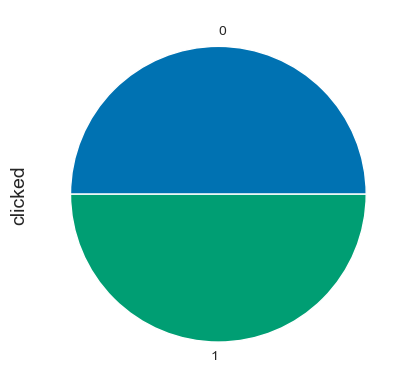

In [310]:
# value_counts().plot(kind='pie'):  hacer conteo de clases y plot tipo 'pie'
y_train.value_counts().plot(kind='pie')
y_train.value_counts(normalize=True)

1    0.5
0    0.5
Name: clicked, dtype: float64

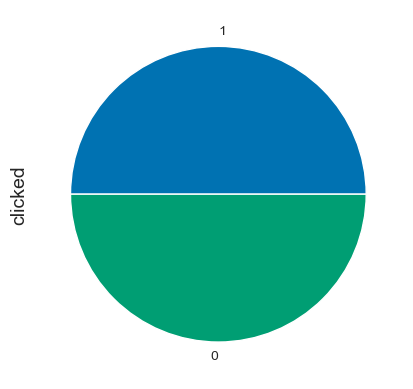

In [311]:
# value_counts().plot(kind='pie'):  hacer conteo de clases y plot tipo 'pie'
y_test.value_counts().plot(kind='pie')
y_test.value_counts(normalize=True)

In [312]:
x_train

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.540441
1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0.470588
2,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0.540441
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.540441
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.540441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0.540441
802,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.540441
803,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0.540441
804,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.540441


In [313]:
x_test

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0.540441
1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.540441
2,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0.470588
3,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0.540441
4,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0.394737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0.540441
198,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0.375000
199,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0.394737
200,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.435487


## Estandarización

In [314]:
# guardar columnas de variables para DataFrame
cols_train =  x_train.columns
cols_test =  x_test.columns


In [315]:
# crear escalador Estandar
# ajustar escalador con datos de entrenamiento
escalador = StandardScaler()
escalador.fit(x_train[['time_of_day_tree_discret']])

# transformar variables x con escalador entrenado con datos de entrenamiento
x_train['time_of_day_tree_discret'] = escalador.transform(x_train[['time_of_day_tree_discret']])
x_test['time_of_day_tree_discret'] = escalador.transform(x_test[['time_of_day_tree_discret']])

# convertir variables a DataFrame
x_train = pd.DataFrame(x_train, columns = cols_train)
x_test = pd.DataFrame(x_test, columns = cols_test)


In [316]:
x_train

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.665049
1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,-0.391041
2,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0.665049
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.665049
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.665049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0.665049
802,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.665049
803,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0.665049
804,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.665049


In [317]:
x_test

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0.665049
1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.665049
2,0,0,0,0,1,0,0,0,1,0,1,0,0,0,-0.391041
3,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0.665049
4,0,0,0,0,1,0,1,0,0,0,0,0,0,1,-1.537820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0.665049
198,1,0,0,0,0,0,0,1,0,0,0,0,1,0,-1.836217
199,0,0,0,1,0,0,0,1,0,0,1,0,0,0,-1.537820
200,0,0,0,0,0,0,0,0,1,0,0,1,0,0,-0.921732


## Guardar Bases de Datos

In [318]:
# base de datos de entrenamiento
x_train.to_csv('data/x_train.csv')
y_train.to_csv('data/y_train.csv')

# base de datos de prueba
x_test.to_csv('data/x_test.csv')
y_test.to_csv('data/y_test.csv')


# Exploración

* Análisis Descriptivo
* Análisis Estadístico
* Visualización
* Técnicas de correlación
* Aprendizaje no Supervisado

## Análisis Descriptivo

In [319]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   copy         1000 non-null   object
 1   audience     1000 non-null   object
 2   keywords     1000 non-null   object
 3   time_of_day  1000 non-null   int64 
 4   clicked      1000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [320]:
# contar observaciones(fila) por clase de variable
y.value_counts()

0    504
1    496
Name: clicked, dtype: int64

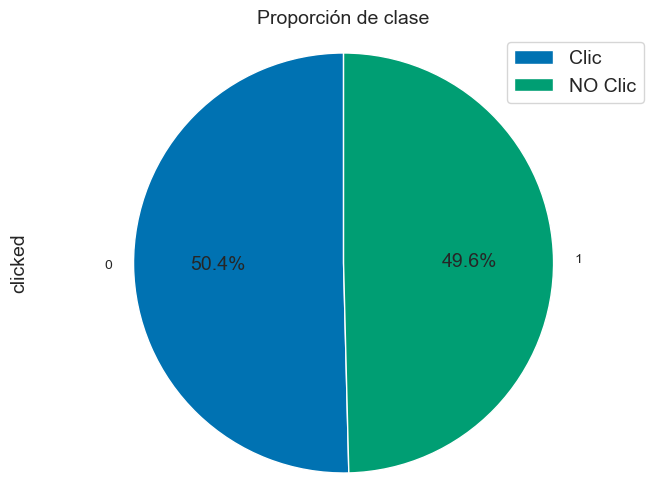

In [321]:
# calcular proporcion de clase

# variable y dependiente (target)
# y= 'clicked'
y.value_counts()
# calcular proporcion de clases
class_proportions = y.value_counts(normalize=True)

# crear pie plot
plt.figure(figsize=(8, 6))
class_proportions.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Proporción de clase')
plt.legend(labels=['Clic','NO Clic'], loc='best')
plt.axis('equal')

# Show the plot
plt.show()

0    0.504
1    0.496
Name: clicked, dtype: float64

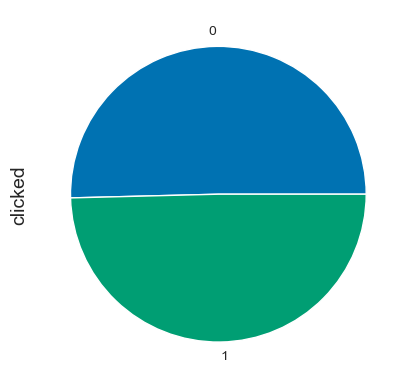

In [322]:
# distribucion de clases
# 1=clic, 0=no clic
y.value_counts().plot(kind='pie')
y.value_counts(normalize=True)

In [323]:
# análisis estadístico preliminar para variables numéricas
# contar observaciones(filas) por variable
# promedio, desviacion estandar
# valor máximo, mínnimo y cuantiles por columna (variable)

data_copy.describe()

,time_of_day,clicked
count,1000.00000,1000.000000
mean,11.30500,0.496000
std,6.92025,0.500234
min,0.00000,0.000000
25%,5.00000,0.000000
50%,12.00000,0.000000
75%,17.00000,1.000000
max,23.00000,1.000000


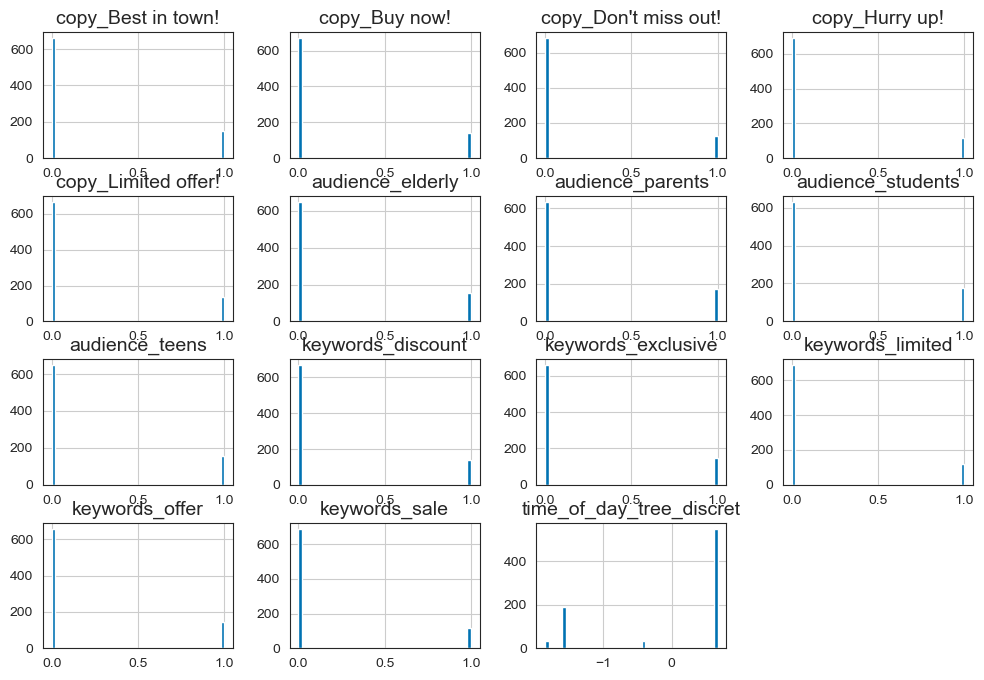

In [324]:
# Plot hisogramas de distrubucion de variables numéricas en base de datos
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

x_train.hist(bins=50, figsize=(12, 8))
plt.show()


## Visualización

Image saved at ./data/Barplot_audience_clicked.png


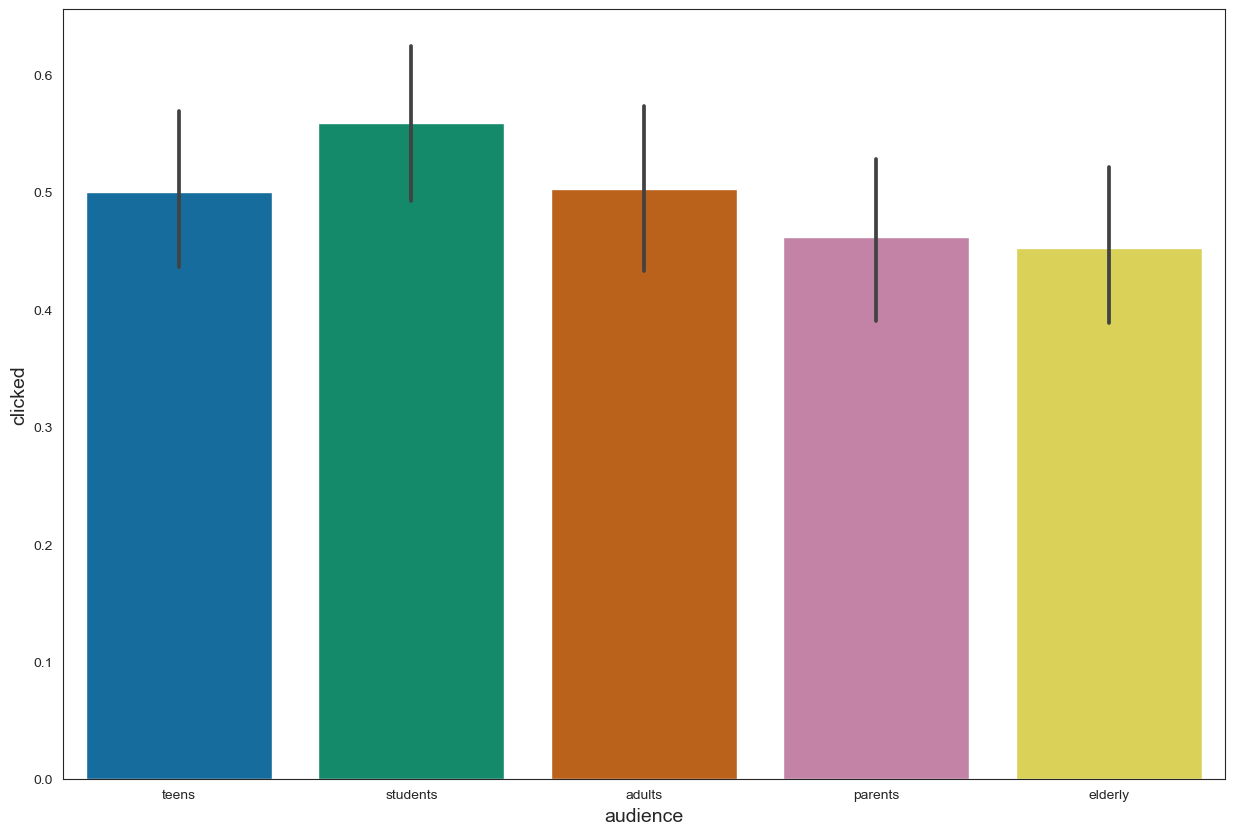

In [325]:
# gráfico de barra  
# y 'clicked' vs. 'audience'
explore.discrete_var_barplot(x='audience',y='clicked',data=data_copy,output_path='./data/')

Image saved at ./data\Countplot_clicked.png


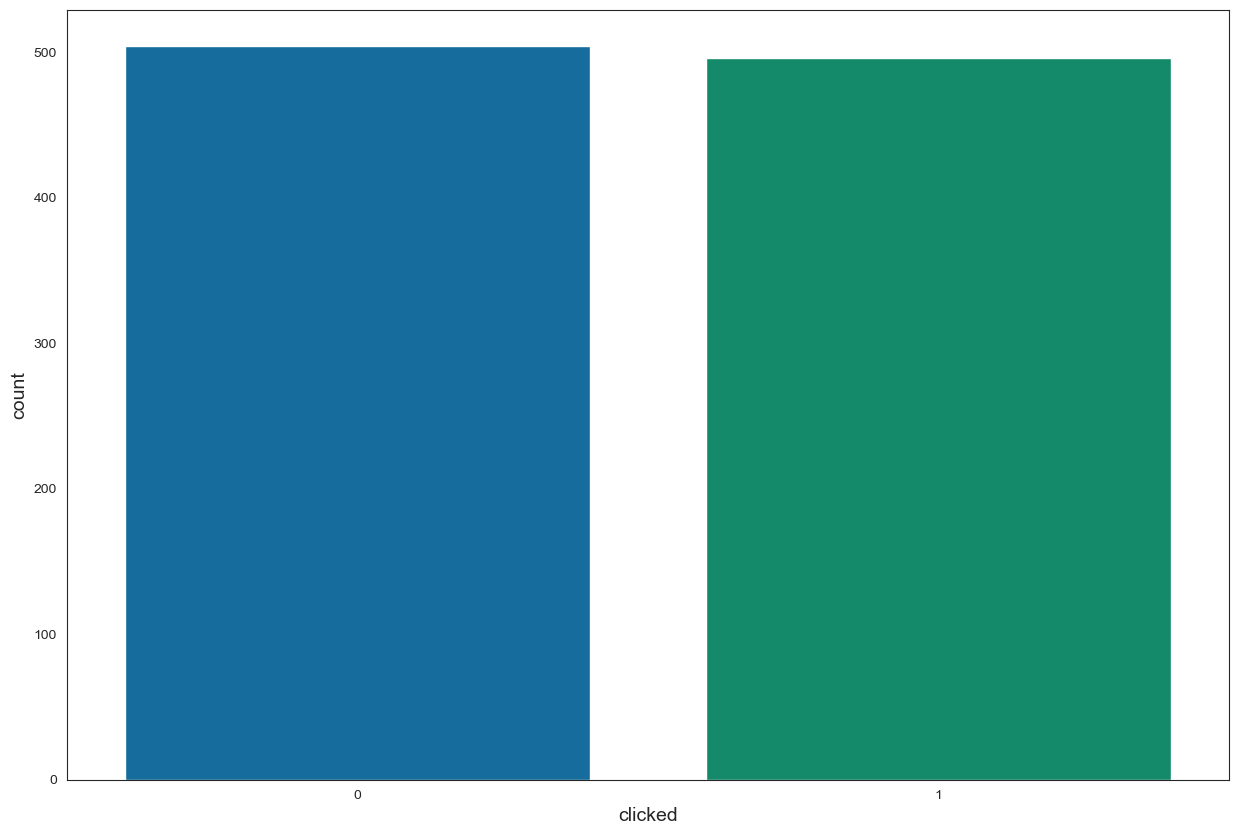

In [326]:
# count plot: contar observaciones por categoria en columna 
# x= 'clicked'
explore.discrete_var_countplot(x='clicked',data=data_copy,output_path='./data')

Image saved at ./data\Boxplot_audience_clicked.png


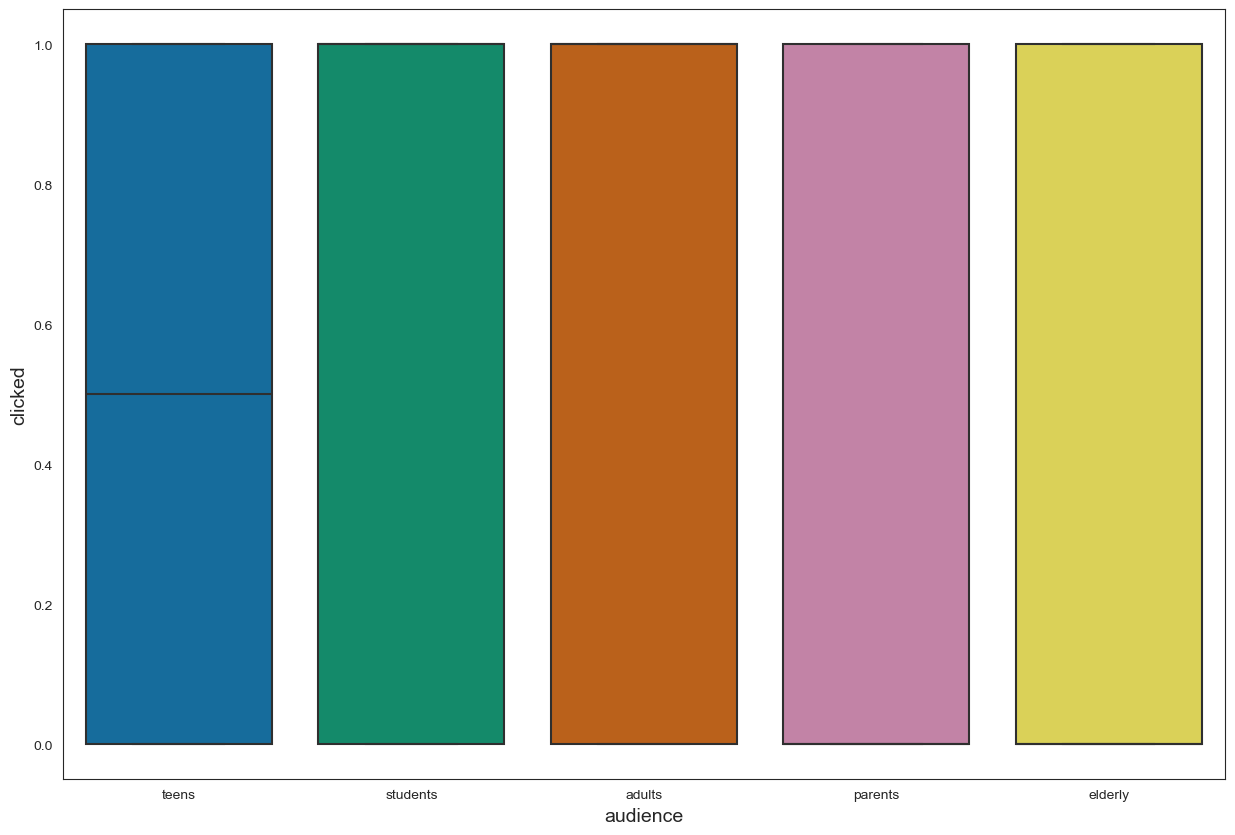

In [327]:
# box plot 
# y 'clicked' vs. x 'audience'
explore.discrete_var_boxplot(x='audience',y='clicked',data=data_copy,output_path='./data')

## Técnicas de Correlación

In [328]:
# crear matriz de correlación entre variables numericas en base de datos 
x_corr = x_train
x_corr['clicked'] = y_train
corr_matrix =x_corr.corr()
corr_matrix

x_corr

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret,clicked
0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.665049,0
1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,-0.391041,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0.665049,1
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.665049,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.665049,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0.665049,1
802,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.665049,1
803,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0.665049,1
804,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.665049,1


In [329]:
# correlación con 'variable ' especifica target
corr_matrix["clicked"].sort_values(ascending=False)

clicked                     1.000000
time_of_day_tree_discret    0.134864
copy_Limited offer!         0.092221
audience_students           0.057177
keywords_offer              0.054619
keywords_discount           0.036126
keywords_sale               0.035347
audience_teens              0.006250
copy_Buy now!               0.003303
copy_Best in town!         -0.009639
audience_elderly           -0.037684
audience_parents           -0.045520
copy_Hurry up!             -0.056554
keywords_exclusive         -0.057680
keywords_limited           -0.069707
copy_Don't miss out!       -0.106251
Name: clicked, dtype: float64

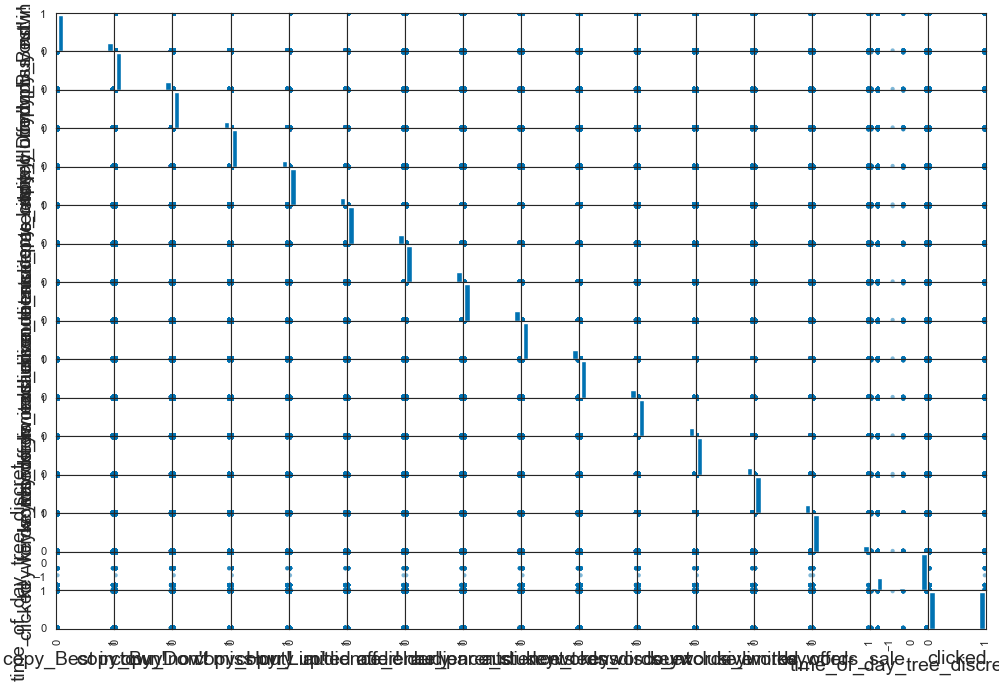

In [330]:
# Plot matriz de dispersion entre variables numéricas
# variables numericas: "time_of_day", "clicked"
#attributes = df.columns
scatter_matrix(x_corr[x_corr.columns], figsize=(12, 8))
plt.show()



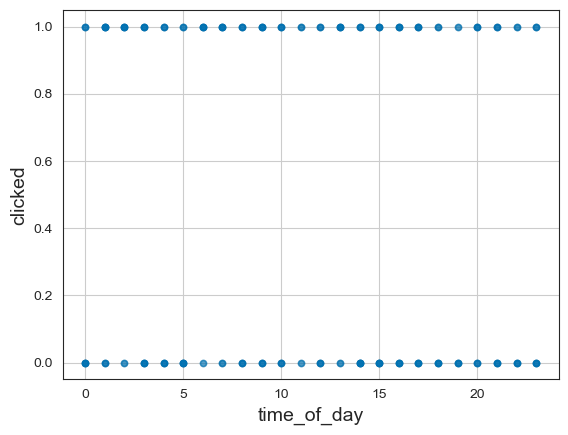

In [331]:
# gráfico de dispersión entre variables numéricas
data_copy.plot(kind="scatter", x="time_of_day", y="clicked",
             alpha=0.1, grid=True)
plt.show()

Image saved at ./data/Corr_plot.png


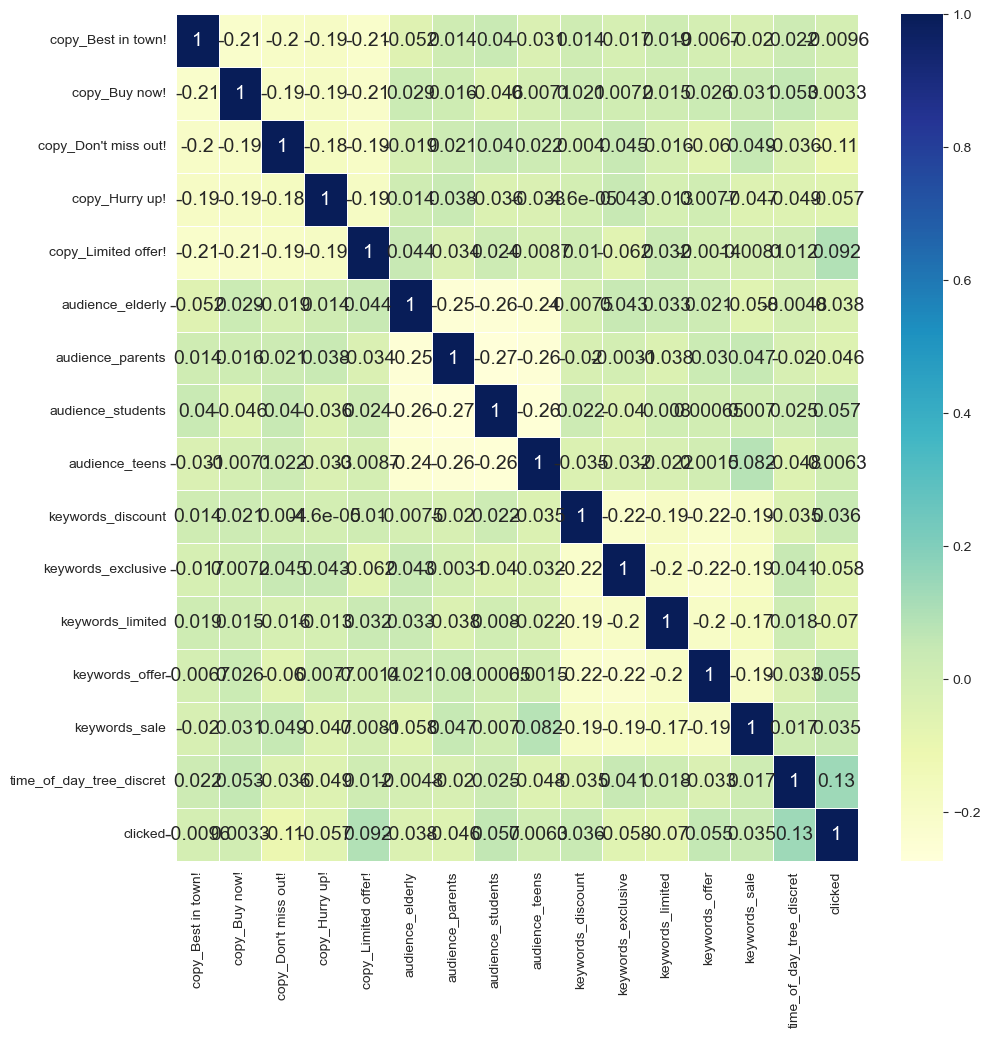

In [332]:
# gráfico de correlación entre columnas (variables) de DataFrame
explore.correlation_plot(data=x_corr,output_path='./data/')


# ML

In [333]:
# cargar bases de datos pre-procesadas
x_train = pd.read_csv('data/x_train.csv') 
y_train = pd.read_csv('data/y_train.csv')

x_test = pd.read_csv('data/x_test.csv')
y_test = pd.read_csv('data/y_test.csv')

# quitar primera columna
x_train.pop(x_train.columns[0])
y_train.pop(y_train.columns[0])
x_test.pop(x_test.columns[0])
y_test.pop(y_test.columns[0])


0        0
1        1
2        2
3        3
4        4
      ... 
197    197
198    198
199    199
200    200
201    201
Name: Unnamed: 0, Length: 202, dtype: int64

## GridSearch

Sintonizador de hiper-parámetros

In [334]:
# Sintonización de Hiperparámetros

# crear modelos de ML
lr = LogisticRegression(n_jobs=-1, random_state=100)
dt = DecisionTreeClassifier(splitter='best', random_state=100)
rf = RandomForestClassifier(n_jobs=-1, max_features = 3, verbose = 1, random_state=100)
ada = AdaBoostClassifier(random_state=100)
xgb = XGBClassifier(max_depth = 7, verbosity=3, random_state=100)
bagging = BaggingClassifier(n_estimators = 100, n_jobs=-1, random_state= 100, verbose = 3)


# grids de hiper parámetros de cada modelo
#Regresión Logística
para_lr = { 'penalty': ['l2'], 'C':np.linspace(0.01,50,num=20,dtype=float) }
grid_lr = GridSearchCV(lr, param_grid=para_lr, scoring= 'recall', n_jobs=-1, cv=5, verbose = 3)

#Árbol de Decisión
para_dt = { 'criterion': ['gini','entropy'], 'max_depth': np.linspace(1,50,num=5,dtype=int), 'min_samples_split': np.linspace(9,20,num=5,dtype=int), 'min_samples_leaf': np.linspace(1,100,num=5,dtype=int)}
grid_dt = GridSearchCV(dt, param_grid=para_dt, scoring= 'recall', n_jobs=-1, cv=5, verbose = 3)

#Random Forest
params_rf = {'n_estimators':np.linspace(100,500,num=3,dtype=int),'criterion':['gini'], 'max_depth': np.linspace(1,50,num=3,dtype=int), 'min_samples_split': np.linspace(9,20,num=3,dtype=int) }  # 'min_samples_leaf':np.linspace(2,30,num=3,dtype=int), 'max_features':[3,6,9], 'oob_score':[True,False]
grid_rf = GridSearchCV(rf, param_grid=params_rf, scoring= 'recall', n_jobs=-1, cv=5, verbose = 3)

#AdaBoost
params_ada = {'n_estimators':np.linspace(50,600,num=3,dtype=int), 'learning_rate':np.linspace(0.01,1,num=3,dtype=float) }
grid_ada =  GridSearchCV(ada, param_grid=params_ada, scoring= 'recall', n_jobs=-1, cv=5, verbose = 3)

#XGBoost
params_xgb = {'n_estimators':np.linspace(50,600,num=3,dtype=int), 'learning_rate':np.linspace(0.01,1,num=3,dtype=float)} # 'booster':['gbtree','dart']
rs_xgb =  RandomizedSearchCV(xgb, param_distributions=params_xgb, scoring= 'recall', n_jobs=-1, cv=5, verbose = 3)

#Bagging
params_bagg = { 'oob_score':[True,False] }
grid_bagg =  GridSearchCV(bagging, param_grid=params_bagg, scoring= 'recall', cv=5, verbose = 3)



In [335]:
x_train

,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale,time_of_day_tree_discret
0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.665049
1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,-0.391041
2,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0.665049
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.665049
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.665049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0.665049
802,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.665049
803,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0.665049
804,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.665049


In [336]:
y_train

,clicked
0,0
1,0
2,1
3,0
4,1
...,...
801,1
802,1
803,1
804,1


## Entrenamiento

In [337]:
# ajustar/entrenar los optimizador de hiperparametros GridSearchCV de cada modelo
grid_lr.fit(x_train, y_train)
joblib.dump(grid_lr, 'data/models/grid_lr1.pkl')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['data/models/grid_lr1.pkl']

In [338]:
grid_dt.fit(x_train, y_train)
joblib.dump(grid_dt, 'data/models/grid_dt.pkl')

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


['data/models/grid_dt.pkl']

In [339]:
grid_rf.fit(x_train, y_train)
joblib.dump(grid_rf, 'data/models/grid_rf.pkl')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


['data/models/grid_rf.pkl']

In [340]:
grid_ada.fit(x_train, y_train)
joblib.dump(grid_ada, 'data/models/grid_ada.pkl')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['data/models/grid_ada.pkl']

In [341]:
rs_xgb.fit(x_train, y_train)
joblib.dump(rs_xgb, 'data/models/rs_xgb.pkl')

c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[22:20:11] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[22:20:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=7
[22:20:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=7
[22:20:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=7
[22:20:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=7
[22:20:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=7
[22:20:11] INFO: C:\Users\dev-admin\cro

['data/models/rs_xgb.pkl']

In [342]:
# ajustar/entrenar los optimizador de hiperparametros GridSearchCV de cada modelo
grid_bagg.fit(x_train, y_train)
joblib.dump(grid_bagg, 'data/models/grid_bagg.pkl')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out

[CV 1/5] END ....................oob_score=True;, score=0.617 total time=   0.1s


[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | 

[CV 2/5] END ....................oob_score=True;, score=0.512 total time=   0.1s
[CV 3/5] END ....................oob_score=True;, score=0.487 total time=   0.1s
[CV 4/5] END ....................oob_score=True;, score=0.617 total time=   0.1s


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out

[CV 5/5] END ....................oob_score=True;, score=0.654 total time=   0.1s
[CV 1/5] END ...................oob_score=False;, score=0.617 total time=   0.0s


[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | 

[CV 2/5] END ...................oob_score=False;, score=0.512 total time=   0.0s
[CV 3/5] END ...................oob_score=False;, score=0.487 total time=   0.0s


[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | 

[CV 4/5] END ...................oob_score=False;, score=0.617 total time=   0.0s
[CV 5/5] END ...................oob_score=False;, score=0.654 total time=   0.0s


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out

['data/models/grid_bagg.pkl']

## Selección de Modelo

In [ ]:
lr = LogisticRegression(n_jobs=-1, random_state=1)

dt = DecisionTreeClassifier(splitter='best', random_state=1)

rf = RandomForestClassifier(n_jobs=-1, verbose = 0, random_state=1)

ada = AdaBoostClassifier(random_state=1)

xgb = XGBClassifier(verbosity=0, random_state=1, validate_parameters=True, objective='multi_softmax')

bagging = BaggingClassifier(n_jobs=-1, random_state= 1, verbose = 0)

extra= ExtraTreesClassifier(n_jobs=-1, random_state= 1, verbose = 0)

lgb = LGBMClassifier(n_jobs=-1, random_state= 1)

In [343]:
# extraer mejores modelos sintonizados para cada modelo
lr_op = grid_lr.best_estimator_
dt_op = grid_dt.best_estimator_
rf_op = grid_rf.best_estimator_
ada_op = grid_ada.best_estimator_
xgb_op = rs_xgb.best_estimator_
bagg_op = grid_bagg.best_estimator_

# extraer mejores métricas de evaluacion promedio (validacion cruzada) de cada modelo 
mean_lr_score = grid_lr.best_score_
mean_dt_score = grid_dt.best_score_
mean_rf_score = grid_rf.best_score_
mean_ada_score = grid_ada.best_score_
mean_xgb_score = rs_xgb.best_score_
mean_bagg_score = grid_bagg.best_score_


# print los mejores hiper parametros de cada modelo
print("Mejores score de Promedio K-Fold Regresión Logistica:", mean_lr_score)
print("Mejores score de Promedio K-Fold Árbol de Decisión:", mean_dt_score)
print("Mejores score de Promedio K-Fold Random Forest:", mean_rf_score)
print("Mejores score de Promedio K-Fold AdaBoost:", mean_ada_score)
print("Mejores score de Promedio K-Fold XGBoost:", mean_xgb_score)
print("Mejores score de Promedio K-Fold XGBoost:", mean_bagg_score)


# lista de mejores modelos de cada modelo 
classifiers = [('Regresión Logística', lr_op),
               ('Árbol de Decisión', dt_op), ('Random Forest', rf_op), ('AdaBoost', ada_op),
               ('Bagging', bagg_op), ('XGBoost', xgb_op)]

classifier_names = []


# crear listas de métricas de evaluacion

classifier_acc = []# (TP+TN)/TOT
classifier_rec = []# rec = 1-FNR
classifier_spec = []# spec = 1-FPR
classifier_prec= []# prec = 1-FDR
classifier_f1 = []# media armonica entre prec y rec

for classifier_name, classifier in classifiers:
 
    # ajustar modelo sintonizado con datos de entrenamiento
    classifier.fit(x_train, y_train)    
    
    # crear y_predict vector de predicciones
    y_predict = classifier.predict(x_test)
    
    # calcular matriz de confusion
    print(pd.DataFrame(confusion_matrix(y_test, y_predict)))
    print('')
    confusion = confusion_matrix(y_test, y_predict)    
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict ).ravel()
    spec = tn / (tn+fp)
    
    # calcular scoring = 'specificity'
    specificity = specificity1 = confusion[1,1]/(confusion[1,0]+confusion[1,1])
    
    # calcular métricas de evaluación
    accuracy = accuracy_score(y_test,y_predict)
    recall = recall_score(y_test,y_predict)
    precision = precision_score(y_test,y_predict)
    f1 = f1_score(y_test,y_predict)
    
    
    # Evaluación del clasificador
    print('{:s} : {:.2f}'.format(classifier_name, specificity))
    classifier_names.append(classifier_name)
    classifier_spec.append(specificity)
    
    print('{:s} : {:.2f}'.format(classifier_name, accuracy))
    classifier_acc.append(accuracy)
    
    print('{:s} : {:.2f}'.format(classifier_name, recall))
    classifier_rec.append(recall)
    
    print('{:s} : {:.2f}'.format(classifier_name, precision))
    classifier_prec.append(precision)
    
    print('{:s} : {:.2f}'.format(classifier_name, f1))
    classifier_f1.append(f1)



c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores score de Promedio K-Fold Regresión Logistica: 0.6945061728395062
Mejores score de Promedio K-Fold Árbol de Decisión: 0.7640432098765432
Mejores score de Promedio K-Fold Random Forest: 0.5926543209876542
Mejores score de Promedio K-Fold AdaBoost: 0.70429012345679
Mejores score de Promedio K-Fold XGBoost: 0.6052469135802468
Mejores score de Promedio K-Fold XGBoost: 0.5777777777777777
    0   1
0  34  67
1  38  63

Regresión Logística : 0.62
Regresión Logística : 0.48
Regresión Logística : 0.62
Regresión Logística : 0.48
Regresión Logística : 0.55
    0   1
0  25  76
1  32  69

Árbol de Decisión : 0.68
Árbol de Decisión : 0.47
Árbol de Decisión : 0.68
Árbol de Decisión : 0.48
Árbol de Decisión : 0.56


c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Diego\anaconda3\Lib\site-package

    0   1
0  48  53
1  40  61

Random Forest : 0.60
Random Forest : 0.54
Random Forest : 0.60
Random Forest : 0.54
Random Forest : 0.57
    0   1
0  34  67
1  40  61

AdaBoost : 0.60
AdaBoost : 0.47
AdaBoost : 0.60
AdaBoost : 0.48
AdaBoost : 0.53
    0   1
0  55  46
1  45  56

Bagging : 0.55
Bagging : 0.55
Bagging : 0.55
Bagging : 0.55
Bagging : 0.55
[22:20:13] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[22:20:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=7
[22:20:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=7
[22:20:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=7
[22:20:13] INFO: C:\Us

[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


## Gráficas 

C:\Users\Diego\AppData\Local\Temp\ipykernel_6012\3991237368.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classifier_names)
C:\Users\Diego\AppData\Local\Temp\ipykernel_6012\3991237368.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)


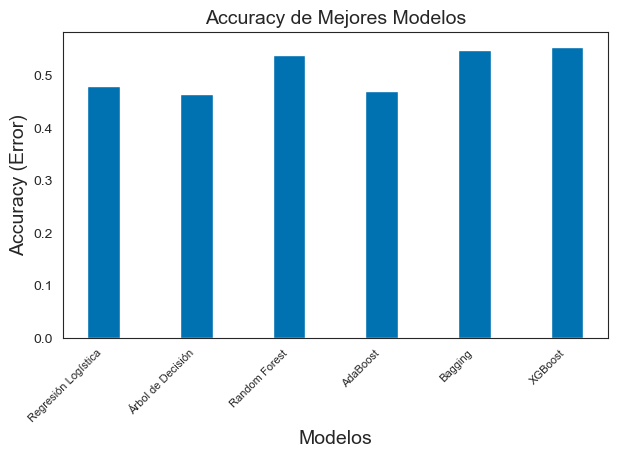

[0.4801980198019802,
 0.46534653465346537,
 0.5396039603960396,
 0.47029702970297027,
 0.5495049504950495,
 0.5544554455445545]

In [344]:
# Accuracy

# Create figure and axis
fig, ax = plt.subplots()

# Plotting the bars
bar_width = 0.35
ax.bar(classifier_names, classifier_acc, width=bar_width, label=classifier_names)

# Adding labels, title, and legend
ax.set_xlabel('Modelos')
ax.set_ylabel('Accuracy (Error)')
ax.set_title('Accuracy de Mejores Modelos')
ax.set_xticklabels(classifier_names)
ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)
#ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

classifier_acc


C:\Users\Diego\AppData\Local\Temp\ipykernel_6012\3640175212.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classifier_names)
C:\Users\Diego\AppData\Local\Temp\ipykernel_6012\3640175212.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)


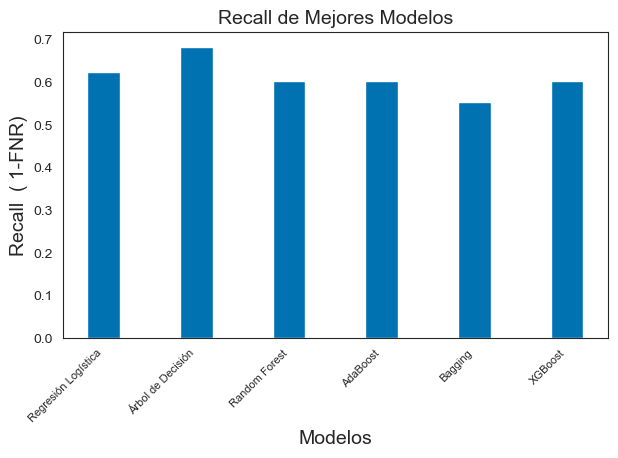

[0.6237623762376238,
 0.6831683168316832,
 0.6039603960396039,
 0.6039603960396039,
 0.5544554455445545,
 0.6039603960396039]

In [345]:
# Recall
# Create figure and axis
fig, ax = plt.subplots()

# Plotting the bars
bar_width = 0.35
ax.bar(classifier_names, classifier_rec, width=bar_width, label=classifier_names)

# Adding labels, title, and legend
ax.set_xlabel('Modelos')
ax.set_ylabel('Recall  ( 1-FNR)')
ax.set_title('Recall de Mejores Modelos')
ax.set_xticklabels(classifier_names)
ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)
#ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

classifier_rec


C:\Users\Diego\AppData\Local\Temp\ipykernel_6012\2660832596.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classifier_names)
C:\Users\Diego\AppData\Local\Temp\ipykernel_6012\2660832596.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)


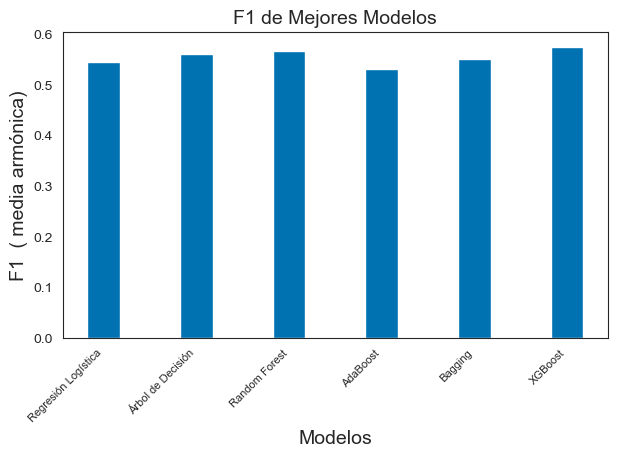

[0.5454545454545455,
 0.5609756097560976,
 0.5674418604651162,
 0.5327510917030567,
 0.5517241379310345,
 0.5754716981132076]

In [346]:
# F1- Score (media armónica entre precisión y recall)
# Create figure and axis
fig, ax = plt.subplots()

# Plotting the bars
bar_width = 0.35
ax.bar(classifier_names, classifier_f1, width=bar_width, label=classifier_names)

# Adding labels, title, and legend
ax.set_xlabel('Modelos')
ax.set_ylabel('F1  ( media armónica)')
ax.set_title('F1 de Mejores Modelos')
ax.set_xticklabels(classifier_names)
ax.set_xticklabels(classifier_names, rotation=45, ha='right', fontsize=8)
#ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

classifier_f1

## Reporte de Clasificación

In [354]:
y_pred_lr= lr_op.predict(x_test)
print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

           0       0.47      0.34      0.39       101
           1       0.48      0.62      0.55       101

    accuracy                           0.48       202
   macro avg       0.48      0.48      0.47       202
weighted avg       0.48      0.48      0.47       202



In [357]:
y_pred_dt= dt_op.predict(x_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.44      0.25      0.32       101
           1       0.48      0.68      0.56       101

    accuracy                           0.47       202
   macro avg       0.46      0.47      0.44       202
weighted avg       0.46      0.47      0.44       202



In [356]:
y_pred_rf= rf_op.predict(x_test)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.55      0.48      0.51       101
           1       0.54      0.60      0.57       101

    accuracy                           0.54       202
   macro avg       0.54      0.54      0.54       202
weighted avg       0.54      0.54      0.54       202



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [358]:
y_pred_dt = dt_op.predict(x_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.44      0.25      0.32       101
           1       0.48      0.68      0.56       101

    accuracy                           0.47       202
   macro avg       0.46      0.47      0.44       202
weighted avg       0.46      0.47      0.44       202



In [359]:
y_pred_ada = ada_op.predict(x_test)
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

           0       0.46      0.34      0.39       101
           1       0.48      0.60      0.53       101

    accuracy                           0.47       202
   macro avg       0.47      0.47      0.46       202
weighted avg       0.47      0.47      0.46       202



In [360]:
y_pred_xgb = xgb_op.predict(x_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.56      0.50      0.53       101
           1       0.55      0.60      0.58       101

    accuracy                           0.55       202
   macro avg       0.55      0.55      0.55       202
weighted avg       0.55      0.55      0.55       202



In [361]:
y_pred_bagging = bagg_op.predict(x_test)
print(classification_report(y_test, y_pred_bagging))

              precision    recall  f1-score   support

           0       0.55      0.54      0.55       101
           1       0.55      0.55      0.55       101

    accuracy                           0.55       202
   macro avg       0.55      0.55      0.55       202
weighted avg       0.55      0.55      0.55       202



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


A partir de los resultados encontrados, teniendo en cuenta que la métrica de evaluación que se desea optimizar es el recall (minimizar la tasa de Falsos Negativos), se escogió el modelo XGBoost optimizado en sintonización como con mejor score de Promedio en validación cruzada K-Fold XGBoost: 0.5962962962962963.

## Evaluación Final

Accuracy 0.55446
Precision 0.54955
Sensitivity/Recall 0.60396
Balanced Accuracy 0.55446
F1 0.57547
    0   1
0  51  50
1  40  61
[[51 50]
 [40 61]]


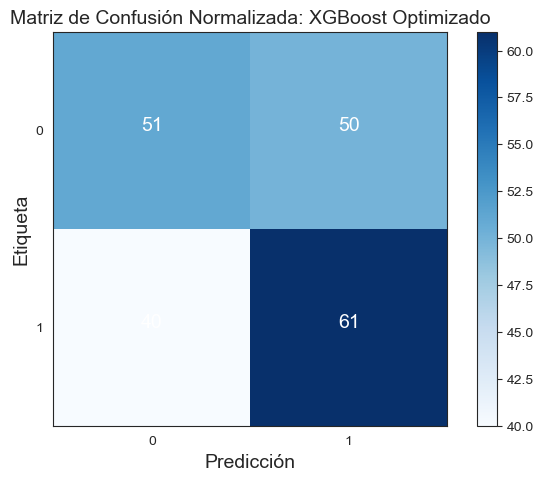

In [362]:

# crear predicciones con x-test
y_predict = xgb_op.predict(x_test) # Realice la predicción de etiquetas con los datos de prueba del conjunto C #

# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict),5)}')
print(f'Precision {round(precision_score(y_test, y_predict),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict),5)}')
print(f'F1 {round(f1_score(y_test, y_predict),5)}')


print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: XGBoost Optimizado')

Mediante la sintonización de parámetros se logró mejorar el modelo XGBoost base de 0.51 a 0.55 y el recall(tasa de Falsos Negativos) de 0.483 a 0.6039. Las otras métrica de clasificación binaria más relevantes encontradas en el modelo final son: 

Accuracy 0.55446

Precision 0.54955

Sensitivity/Recall 0.60396

Balanced Accuracy 0.55446


F1 0.57547


# AutoML

## Preprocesamiento

* Dividir bases de datos: Dividir base de datos en datos de entrenamiento y datos de prueba. Se hace al inicio para prevenir filtración y degradación en los datos al momento del entrenamiento
* Codificación: Codificar variables categóricas mediante One-Hot [0-1] en columnas numéricas
* Discretización: Discretización de variable numérica ('time of day) para mejorar el proprocesamiento en bines por Arboles de Decisión
* Tratamiento de clase Desbalanceada: Generar nuevas bases con balance de clase 50/50. Para la base de datos generada este paso es opcional porque ya está balanceda.
* Estandarización: Transformar la distribución de las variables numericas ('time of day') para obtener distribución estandar y evitar sesgos de los pesos.

### Cargar bases de datos

In [3]:
# cargar base de datos
data = h2o.import_file('data/ad_data.csv')

x_h2o = data.columns[:-1]
y_h2o = "clicked"

data["clicked"] = data["clicked"].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
data

copy,audience,keywords,time_of_day,clicked
Hurry up!,teens,bestseller,6,1
50% off!,teens,offer,6,1
Buy now!,students,exclusive,13,1
Buy now!,adults,discount,23,1
Buy now!,adults,bestseller,8,1
Don't miss out!,parents,exclusive,10,0
Hurry up!,adults,bestseller,22,0
Best in town!,elderly,exclusive,3,1
Limited offer!,elderly,offer,6,1
Hurry up!,adults,bestseller,11,0


In [4]:
x_h2o

['copy', 'audience', 'keywords', 'time_of_day']

### Dividir base de datos en entrenamiento y prueba

In [365]:
# dividir bases de datos
train, valid = data.split_frame(ratios=[.8])
train


copy,audience,keywords,time_of_day,clicked
Hurry up!,teens,bestseller,6,1
50% off!,teens,offer,6,1
Buy now!,students,exclusive,13,1
Buy now!,adults,discount,23,1
Buy now!,adults,bestseller,8,1
Hurry up!,adults,bestseller,22,0
Best in town!,elderly,exclusive,3,1
Limited offer!,elderly,offer,6,1
Hurry up!,adults,bestseller,11,0
Don't miss out!,adults,discount,6,0


## GridSearch

Sintonizar hiper-parámetros

In [367]:
# GBM
# parametros: model_id=nombre,  training_frame= datos de entrenamiento, validation_frame=datos de validacion(sintonización)
# nfolds= numero de k-folds, score_each_iteration=True evaluar cada iteracion de entrenamiento
# score_tree_interval=int score los modelos despues de n arboles, 
# stopping_rounds=int parar entrenamiento por covergencia de métrica
# stopping_metric= 'custom','mse' metrica parar entrenamiento antes por convergencia ["auto", "deviance", "logloss", "mse", "rmse", "mae", "rmsle", "auc", "aucpr", "lift_top_group","misclassification", "mean_per_class_error", "custom", "custom_increasing"]
# stopping_tolerance=float tolerancia de parada
# balance_classes=True balancear clases por over/under-sampling, class_sampling_factors: List[float] factor/proporcion de balance de clase
# ntrees= numero de arboles, max_depth: int profundidad de arboles default 20 
# learn_rate=float tasa de aprendizaje, 
# seed=replicabilidad 
# custom_metric_func=custom_func metrica de evaluacion a maximizar, stopping_metric="custom"


# GBM hiper parámetros
# definir grid de hiperparametros a sintonizar 
gbm_params1 = {'ntrees':[100,200,400],
               'max_depth': [7, 10, 20],
               'learn_rate': [0.01, 0.1, 1],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0]}

# RF
# parametros: model_id=nombre,  training_frame= datos de entrenamiento, validation_frame=datos de validacion(sintonización)
# nfolds= numero de k-folds, score_each_iteration=True evaluar cada iteracion de entrenamiento
# balance_classes=True balancear clases por over/under-sampling, class_sampling_factors: List[float] factor/proporcion de balance de clase
# ntrees= numero de arboles, max_depth: int profundidad de arboles default 20,mtries=-1 numero de predictores en cada nodo, 
# seed=replicabilidad 
# custom_metric_func=custom_func metrica de evaluacion a maximizar, stopping_metric="custom"

rf_params1 = {'ntrees':[100,300,500],
               'max_depth': [7, 10, 20],
                'sample_rate': [0.8, 1.0],
                'categorical_encoding': ["auto" "one_hot_internal", "binary", "eigen"] }


# Deep Neural Network: Perceptron Multi-Capa (FeedForward Neural Network)
# Redes Neuronales

# parametros: model_id=nombre,  training_frame= datos de entrenamiento, validation_frame=datos de validacion(sintonización)
# activation: "rectifier" ["tanh", "tanh_with_dropout", "rectifier", "rectifier_with_dropout", "maxout", "maxout_with_dropout"] funcion de activacion
# adaptive_rate= True tasa aprendizaje adaptativa
# balance_classes= True balance de clases,  class_sampling_factors=list[float] ratio de balance de clases
# categorical_encoding= "auto" ["auto", "enum", "one_hot_internal", "one_hot_explicit", "binary", "eigen", "label_encoder", "sort_by_response", "enum_limited"] codificar variables categoricas
# diagnostics=True diagnostico de capas escondidas
# epochs= int  cuantas veces se itera sobre base default 10
# epsilon=float default 1e-08  tasa aprendizaje adaptativa
# fast_mode=True (modo rapido), force_load_balance=True mayor carga de balance mas rapidez

# hidden=List[int] numero x tamaño de capas,  
# ignored_columns=List[str] especifica variables ignoradas, ignore_const_cols=True ignora columnas constantes
# l1=float regularizacion L1, l2=float regularizacion L2, loss ="automatic"["automatic", "cross_entropy", "quadratic", "huber", "absolute", "quantile"] funcion de perdidas, 
# missing_values_handling= "mean_imputation" ["mean_imputation", "skip"] tratamiento de NAs
# nfolds= numero de k-folds, rate=float tasa de aprendizaje, rho=float 0.99 tasa de aprendizaje adapativa
# score_each_iteration=True evaluar cada iteracion de entrenamiento 
# regression_stop=1e-06 OFF=-1 criterio de parada para MSE
# seed=int reproducibilidad 
# standardize=True estandarizar base 

# stopping_metric="auto"/"mse" ["auto", "deviance", "logloss", "mse", "rmse", "mae", "rmsle", "auc", "aucpr", "lift_top_group", "misclassification", "mean_per_class_error", "custom", "custom_increasing"] metrica de parada auto
# stopping_rounds=int 5 numero de rondas que avg(stopping_metric) no mejora, stopping_tolerance=float 0.0005 tolerancia de parada
# variable_importances=True  interpretar modelo por importancia de variables

nn_params1 = {'activation':["tanh_with_dropout", "rectifier", "rectifier_with_dropout"],
               'categorical_encoding': ["auto","one_hot_explicit", "binary"],
               'epochs': [30,50,100,200],
                'hidden': [30,50,100]
                }



gbm_params1, rf_params1, nn_params1



({'ntrees': [100, 200, 400],
  'max_depth': [7, 10, 20],
  'learn_rate': [0.01, 0.1, 1],
  'sample_rate': [0.8, 1.0],
  'col_sample_rate': [0.2, 0.5, 1.0]},
 {'ntrees': [100, 300, 500],
  'max_depth': [7, 10, 20],
  'sample_rate': [0.8, 1.0],
  'categorical_encoding': ['autoone_hot_internal', 'binary', 'eigen']},
 {'activation': ['tanh_with_dropout', 'rectifier', 'rectifier_with_dropout'],
  'categorical_encoding': ['auto', 'one_hot_explicit', 'binary'],
  'epochs': [30, 50, 100, 200],
  'hidden': [30, 50, 100]})

## Entrenamiento

### Gradient Boosting Machine

In [368]:
# crear H2OGridSearch sintonizador de hiperparametros 
gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)
# entrenar H2OGridSearch con datos de entrenamiento, definir parametros fijos
gbm_grid1.train(x=x_h2o, y=y_h2o, 
                training_frame=train, 
                validation_frame=valid, 
                nfolds=5,
                balance_classes=True,
                score_tree_interval=10,     #used for early stopping
                stopping_rounds=10,         #used for early stopping
                stopping_metric='MSE',     #used for early stopping
                stopping_tolerance=0.005, #used for early stopping
                keep_cross_validation_predictions=True,
                seed=1)


gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,ntrees,sample_rate,model_ids,logloss
,0.2,0.01,7.0,150.0,0.8,gbm_grid1_model_540,0.6840415
,0.2,0.01,7.0,146.0,1.0,gbm_grid1_model_459,0.6854275
,0.2,0.01,20.0,158.0,0.8,gbm_grid1_model_558,0.6854304
,0.2,0.01,7.0,100.0,0.8,gbm_grid1_model_486,0.6856013
,0.2,0.01,10.0,156.0,0.8,gbm_grid1_model_549,0.6856125
,0.2,0.01,7.0,134.0,0.8,gbm_grid1_model_378,0.6857342
,0.2,0.01,10.0,140.0,1.0,gbm_grid1_model_468,0.6861436
,0.2,0.01,20.0,136.0,1.0,gbm_grid1_model_477,0.6861915
,0.2,0.01,20.0,132.0,0.8,gbm_grid1_model_396,0.6862746
,0.2,0.01,10.0,132.0,0.8,gbm_grid1_model_387,0.6864885


In [ ]:
# resultados de sintonización, ordenados por métrica recall
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='recall', decreasing=True)

# mejor modelo GBM
gbm_op = gbm_gridperf1.models[0]

gbm_gridperf1


,col_sample_rate,learn_rate,max_depth,ntrees,sample_rate,model_ids,recall
,0.2,0.01,7.0,100.0,0.8,gbm_grid1_model_1,1.0
,0.2,0.01,10.0,100.0,0.8,gbm_grid1_model_10,1.0
,0.2,0.01,20.0,100.0,1.0,gbm_grid1_model_100,1.0
,0.5,0.01,20.0,100.0,1.0,gbm_grid1_model_101,1.0
,1.0,0.01,20.0,100.0,1.0,gbm_grid1_model_102,1.0
,0.2,0.1,20.0,100.0,1.0,gbm_grid1_model_103,1.0
,0.5,0.1,20.0,100.0,1.0,gbm_grid1_model_104,1.0
,1.0,0.1,20.0,100.0,1.0,gbm_grid1_model_105,1.0
,0.2,1.0,20.0,100.0,1.0,gbm_grid1_model_106,1.0
,0.5,1.0,20.0,100.0,1.0,gbm_grid1_model_107,1.0


In [ ]:
# resultados de sintonización, ordenados por métrica accuracy
gbm_gridperf2 = gbm_grid1.get_grid(sort_by='accuracy', decreasing=True)

# mejor modelo GBM
gbm_op2 = gbm_gridperf2.models[0]

gbm_gridperf2

,col_sample_rate,learn_rate,max_depth,ntrees,sample_rate,model_ids,accuracy
,0.5,1.0,20.0,132.0,0.8,gbm_grid1_model_242,0.5693069
,0.5,1.0,20.0,132.0,0.8,gbm_grid1_model_80,0.5693069
,1.0,1.0,20.0,136.0,0.8,gbm_grid1_model_243,0.5618812
,1.0,1.0,20.0,136.0,0.8,gbm_grid1_model_81,0.5618812
,1.0,0.01,7.0,200.0,1.0,gbm_grid1_model_111,0.5594059
,1.0,0.01,7.0,200.0,1.0,gbm_grid1_model_273,0.5594059
,0.5,1.0,20.0,100.0,0.8,gbm_grid1_model_188,0.5581683
,1.0,0.1,7.0,200.0,0.8,gbm_grid1_model_195,0.5581683
,0.5,1.0,20.0,100.0,0.8,gbm_grid1_model_26,0.5581683
,1.0,0.1,7.0,200.0,0.8,gbm_grid1_model_33,0.5581683


### Random Forest Model

In [ ]:
# crear H2OGridSearch sintonizador de hiperparametros 
rf_grid1 = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='rf_grid1',
                          hyper_params=rf_params1)

# entrenar H2OGridSearch con datos de entrenamiento, definir parametros fijos
rf_grid1.train(x=x_h2o, y=y_h2o, 
                training_frame=train, 
                validation_frame=valid, 
                nfolds=5,
                mtries=-1,
                balance_classes=True,
                score_each_iteration=True,
                score_tree_interval=10,     #used for early stopping
                stopping_rounds=10,         #used for early stopping
                stopping_metric='MSE',     #used for early stopping
                stopping_tolerance=0.005, #used for early stopping
                keep_cross_validation_predictions=True,
                seed=1)



drf Grid Build progress: |

███████████████████████████████████████████████████████| (done) 100%
Errors/Warnings building gridsearch model

failure_details: Cannot set field 'categorical_encoding' to value autoone_hot_internal
failure_stack_traces: java.lang.IllegalArgumentException: Cannot set field 'categorical_encoding' to value autoone_hot_internal
	at water.api.GridSearchHandler$ModelParametersFromSchemaBuilder.set(GridSearchHandler.java:254)
	at water.api.GridSearchHandler$ModelParametersFromSchemaBuilder.set(GridSearchHandler.java:231)
	at hex.grid.HyperSpaceWalker$BaseWalker.getModelParams(HyperSpaceWalker.java:304)
	at hex.grid.HyperSpaceWalker$CartesianWalker$1.nextModelParameters(HyperSpaceWalker.java:448)
	at hex.grid.GridSearch.gridSearch(GridSearch.java:412)
	at hex.grid.GridSearch.access$900(GridSearch.java:70)
	at hex.grid.GridSearch$1.compute2(GridSearch.java:165)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1689)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.Fork

,categorical_encoding,max_depth,ntrees,sample_rate,model_ids,logloss
,Binary,7.0,22.0,0.8,rf_grid1_model_1,0.7157517
,Binary,7.0,22.0,0.8,rf_grid1_model_13,0.7157517
,Binary,7.0,22.0,0.8,rf_grid1_model_37,0.7157517
,Binary,7.0,22.0,0.8,rf_grid1_model_43,0.7157517
,Binary,7.0,22.0,0.8,rf_grid1_model_49,0.7157517
,Binary,7.0,22.0,0.8,rf_grid1_model_7,0.7157517
,Binary,7.0,28.0,1.0,rf_grid1_model_19,0.7200265
,Binary,7.0,28.0,1.0,rf_grid1_model_25,0.7200265
,Binary,7.0,28.0,1.0,rf_grid1_model_31,0.7200265
,Binary,7.0,28.0,1.0,rf_grid1_model_55,0.7200265


In [ ]:
# resultados de sintonización, ordenados por métrica recall
rf_gridperf1 = rf_grid1.get_grid(sort_by='recall', decreasing=True)

# mejor modelo GBM
rf_op = rf_gridperf1.models[0]

rf_gridperf1


,categorical_encoding,max_depth,ntrees,sample_rate,model_ids,recall
,Binary,7.0,22.0,0.8,rf_grid1_model_1,1.0
,Eigen,10.0,20.0,0.8,rf_grid1_model_10,1.0
,Binary,20.0,35.0,0.8,rf_grid1_model_11,1.0
,Eigen,20.0,24.0,0.8,rf_grid1_model_12,1.0
,Binary,7.0,22.0,0.8,rf_grid1_model_13,1.0
,Eigen,7.0,22.0,0.8,rf_grid1_model_14,1.0
,Binary,10.0,40.0,0.8,rf_grid1_model_15,1.0
,Eigen,10.0,20.0,0.8,rf_grid1_model_16,1.0
,Binary,20.0,35.0,0.8,rf_grid1_model_17,1.0
,Eigen,20.0,24.0,0.8,rf_grid1_model_18,1.0


In [ ]:
# resultados de sintonización, ordenados por métrica accuracy
rf_gridperf2 = rf_grid1.get_grid(sort_by='accuracy', decreasing=True)

# mejor modelo GBM
rf_op2 = rf_gridperf2.models[0]

rf_gridperf2

,categorical_encoding,max_depth,ntrees,sample_rate,model_ids,accuracy
,Binary,10.0,40.0,0.8,rf_grid1_model_15,0.5594059
,Binary,10.0,40.0,0.8,rf_grid1_model_3,0.5594059
,Binary,10.0,40.0,0.8,rf_grid1_model_39,0.5594059
,Binary,10.0,40.0,0.8,rf_grid1_model_45,0.5594059
,Binary,10.0,40.0,0.8,rf_grid1_model_51,0.5594059
,Binary,10.0,40.0,0.8,rf_grid1_model_9,0.5594059
,Binary,7.0,28.0,1.0,rf_grid1_model_19,0.5519802
,Binary,20.0,33.0,1.0,rf_grid1_model_23,0.5519802
,Binary,7.0,28.0,1.0,rf_grid1_model_25,0.5519802
,Binary,20.0,33.0,1.0,rf_grid1_model_29,0.5519802


### DeepLearningEstimator

In [ ]:
# crear H2OGridSearch sintonizador de hiperparametros 
dl_grid1 = H2OGridSearch(model=H2ODeepLearningEstimator,
                          grid_id='dl_grid1',
                          hyper_params=nn_params1)

# entrenar H2OGridSearch con datos de entrenamiento, definir parametros fijos
dl_grid1.train(x=x_h2o, y=y_h2o, 
                training_frame=train, 
                validation_frame=valid, 
                adaptive_rate= True,
                balance_classes= True,
                diagnostics=True,
                missing_values_handling= "mean_imputation",
                standardize=True,
                stopping_rounds=10,
                stopping_tolerance=0.005,
                variable_importances=True,
                nfolds=5,
                score_each_iteration=True,
                fast_mode=True,
                keep_cross_validation_predictions=True,
                seed=1)


deeplearning Grid Build progress: |

██████████████████████████████████████████████| (done) 100%
Errors/Warnings building gridsearch model

Hyper-parameter: activation, TanhWithDropout
Hyper-parameter: categorical_encoding, OneHotExplicit
Hyper-parameter: epochs, 30.0
Hyper-parameter: hidden, [30]
failure_details: Illegal argument(s) for DeepLearning model: dl_grid1_model_76.  Details: ERRR on field: _categorical_encoding: Won't use explicit Enum encoding for categoricals - it's much faster with OneHotInternal!
ERRR on field: _categorical_encoding: Won't use explicit Enum encoding for categoricals - it's much faster with OneHotInternal!
ERRR on field: _categorical_encoding: Won't use explicit Enum encoding for categoricals - it's much faster with OneHotInternal!
ERRR on field: _categorical_encoding: Won't use explicit Enum encoding for categoricals - it's much faster with OneHotInternal!
ERRR on field: _categorical_encoding: Won't use explicit Enum encoding for categoricals - it's much faster with OneHotInternal!
ERRR on 

,activation,categorical_encoding,epochs,hidden,model_ids,logloss
,TanhWithDropout,Binary,31.1739673,30.0,dl_grid1_model_7,0.6897727
,TanhWithDropout,OneHotInternal,51.9922945,30.0,dl_grid1_model_10,0.6899376
,TanhWithDropout,OneHotInternal,51.9922945,30.0,dl_grid1_model_82,0.6903974
,TanhWithDropout,OneHotInternal,51.9922945,30.0,dl_grid1_model_82,0.6903974
,TanhWithDropout,OneHotInternal,103.9948471,30.0,dl_grid1_model_19,0.6904742
,TanhWithDropout,Binary,31.1739673,30.0,dl_grid1_model_79,0.6907509
,TanhWithDropout,Binary,31.1739673,30.0,dl_grid1_model_79,0.6907509
,TanhWithDropout,Binary,177.6905332,30.0,dl_grid1_model_106,0.6908508
,TanhWithDropout,Binary,177.6905332,30.0,dl_grid1_model_106,0.6908508
,RectifierWithDropout,Binary,190.3134217,30.0,dl_grid1_model_36,0.6910349


In [ ]:
# resultados de sintonización, ordenados por métrica recall
dl_gridperf1 = dl_grid1.get_grid(sort_by='recall', decreasing=True)

# mejor modelo GBM
dl_op = dl_gridperf1.models[0]

dl_gridperf1

,activation,categorical_encoding,epochs,hidden,model_ids,recall
,TanhWithDropout,OneHotInternal,31.1739673,30.0,dl_grid1_model_1,1.0
,TanhWithDropout,OneHotInternal,51.9922945,30.0,dl_grid1_model_10,1.0
,TanhWithDropout,OneHotInternal,171.1692376,100.0,dl_grid1_model_100,1.0
,Rectifier,OneHotInternal,159.9687556,100.0,dl_grid1_model_101,1.0
,RectifierWithDropout,OneHotInternal,159.9687556,100.0,dl_grid1_model_102,1.0
,TanhWithDropout,Binary,161.5578732,100.0,dl_grid1_model_106,1.0
,Rectifier,Binary,159.9687556,100.0,dl_grid1_model_107,1.0
,RectifierWithDropout,Binary,175.8669033,100.0,dl_grid1_model_108,1.0
,Rectifier,OneHotInternal,51.9922945,30.0,dl_grid1_model_11,1.0
,RectifierWithDropout,OneHotInternal,51.9922945,30.0,dl_grid1_model_12,1.0


In [ ]:
# resultados de sintonización, ordenados por métrica recall
dl_gridperf2 = dl_grid1.get_grid(sort_by='accuracy', decreasing=True)

# mejor modelo GBM
dl_op2 = dl_gridperf2.models[0]

dl_gridperf2

,activation,categorical_encoding,epochs,hidden,model_ids,accuracy
,Rectifier,OneHotInternal,164.8121039,50.0,dl_grid1_model_137,0.5841584
,Rectifier,OneHotInternal,103.9948471,30.0,dl_grid1_model_92,0.5829208
,Rectifier,OneHotInternal,103.9948471,30.0,dl_grid1_model_92,0.5829208
,Rectifier,OneHotInternal,159.9687556,50.0,dl_grid1_model_65,0.5816832
,Rectifier,OneHotInternal,159.9687556,100.0,dl_grid1_model_173,0.5804455
,Rectifier,OneHotInternal,103.9948471,30.0,dl_grid1_model_20,0.5779703
,Rectifier,OneHotInternal,51.9922945,30.0,dl_grid1_model_83,0.5767327
,Rectifier,OneHotInternal,51.9922945,30.0,dl_grid1_model_83,0.5767327
,TanhWithDropout,OneHotInternal,51.9922945,50.0,dl_grid1_model_118,0.5742574
,TanhWithDropout,OneHotInternal,103.9948471,30.0,dl_grid1_model_19,0.5717822


### Ensemble/SuperLearner - Meta Learner

In [ ]:
""" 

# Ensemble/SuperLearner con modelos individuales entrenados 

# parametros: x=nombre de columnas de predictores, y=nombre de columna y_target
# training_frame = datos de entrenamiento, validation_frame = datos de validación(sintonizacion), blending_frame= datos de entrenamiento SuperLearner
# model_id=nombre modelo, base_models=[modelos] k-fold cv keep_cross_validation_prediction=True para todos los modelos base
# metalearner_algorithm = metalearner modelo ["AUTO","glm","gbm","drf","deeplearning","naivebayes","xgboost"], metalearner_params = [parametros SuperLearner]
# metalearner_nfolds=k-folds
# export_checkpoints_dir:filename
# seed:replicabilidad -1

ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial",
                                       base_models=[gbm_op, rf_op, dl_op],
                                       validation_frame=valid,
                                       metalearner_algorithm="AUTO",
                                       metalearner_nfolds=5,
                                       export_checkpoints_dir="data/models/my_ensemble1",
                                       max_runtime_secs=0,
                                        seed=-1)

ensemble.train(x=x_h2o, y=y_h2o, training_frame=train, validation_frame=valid)
  """


In [ ]:

"""
hyper_params = {"learn_rate": [0.01, 0.03],
                "max_depth": [3, 7, 10],
                "sample_rate": [0.7, 0.9, 1.0],
                "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}


search_criteria = {"strategy": "RandomDiscrete", "max_models": 5, "seed": 1}


# sintonizar GridSearch
grid_ensemble = H2OGridSearch(model=H2ODeepLearningEstimator(ntrees=10,
                                                        seed=1,
                                                        nfolds=5,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True),
                     hyper_params=hyper_params,
                     search_criteria=search_criteria,
                     grid_id="gbm_grid_binomial")


# 
grid.train(x=x, y=y, training_frame=train)

"""
# crear criterio de busqueda de GBM
search_criteria = {"strategy": "RandomDiscrete", "max_models": 5, "seed": 1}

# sintonizar GBM 
grid_gbm = H2OGridSearch(model=H2OGradientBoostingEstimator(
                                                        seed=1,
                                                        nfolds=5,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True),
                     hyper_params=gbm_params1,
                     search_criteria=search_criteria,
                     grid_id="gbm_grid_binomial")
# sintonizar GridSearch 
grid_gbm.train(x=x_h2o, y=y_h2o, training_frame=train, validation_frame=valid)

# construir modelo de Ensamble/SuperLearner
# modelos de base son modelos de GBM 
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_gbm_grid_binomial",
                                       base_models=grid_gbm.model_ids)
ensemble.train(x=x_h2o, y=y_h2o, training_frame=train, validation_frame=valid)


gbm Grid Build progress: |

███████████████████████████████████████████████████████| (done) 100%
stackedensemble Model Build progress: |██████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: my_ensemble_gbm_grid_binomial


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  5/5
# GBM base models (used / total)      5/5
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    AUTO
Metalearner nfolds                    0
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.1950958862882524
RMSE: 0.441696599815136
LogLoss: 0.5825706951251394
AUC: 0.9935988227720041
AUCPR: 0.9935322333790088
Gini: 0.9871976455440081
Null degrees of freedom: 807
Residual degrees of freedom: 802
Null deviance: 1119.526759849362
Residual deviance: 941.4342433222253
AIC: 953.4342433222253

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47646116118678916
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      390  25   0.0602   (25.0/415.0)
1      17   376  0.0433   (17.0/393.0)
Total  407  401  0.052    (42.0/808.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476461     0.947103  201
max f2                       0.451944     0.97181   227
max f0point5                 0.507857     0.971682  181
max accuracy                 0.483353     0.94802   197
max precision                0.574735     1         0
max recall                   0.451944     1         227
max specificity              0.574735     1         0
max absolute_mcc             0.476461     0.896194  201
max min_per_class_accuracy   0.482913     0.946988  198
max mean_per_class_accuracy  0.476461     0.948251  201
max tns                      0.574735     415       0
max fns                      0.574735     391       0
max fps                      0.401447     415       399
max tps                      0.451944     393       227
max tnr                      0.574735     1         0
max fnr                      0.574735     0.994911  0
max fpr                      0.401447     1         399
max tpr                      0.451944     1         227

Gains/Lift Table: Avg response rate: 48,64 %, avg score: 48,52 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0111386                   0.574032           2.05598   2.05598            1                0.574419  1                           0.574419            0.0229008       0.0229008                  105.598   105.598            0.0229008
2        0.0222772                   0.572856           2.05598   2.05598            1                0.573418  1                           0.573919            0.0229008       0.0458015                  105.598   105.598            0.0458015
3        0.0309406                   0.571876           2.05598   2.05598            1                0.572178  1                           0.573431            0.0178117       0.0636132                  105.598   105.598            0.0636132
4        0.0420792                   0.570765           2.05598   2.05598            1                0.57117   1                           0.572833            0.0229008       0.086514                   105.598   105.598            0.086514
5        0.0507426                   0.569974           2.05598

### Guardar GridSearch entrenados

In [ ]:
# guardar modelos entrenados
# save the model
h2o.save_model(model=gbm_grid1, path="/data/models")


# load the model
#gbm_grid1 = h2o.load_model(model_path)


In [ ]:
# Load the saved grid search model
loaded_grid = h2o.upload_mojo("grid_search_mojo")

## Selección de Modelo

In [ ]:
gbm_op.model_performance(valid)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.24463099856408868
RMSE: 0.49460185863388006
LogLoss: 0.6820545341315097
Mean Per-Class Error: 0.46568627450980393
AUC: 0.5602941176470588
AUCPR: 0.5601160858145763
Gini: 0.12058823529411766

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34082233175341964
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      7    95   0.9314   (95.0/102.0)
1      0    90   0        (0.0/90.0)
Total  7    185  0.4948   (95.0/192.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.340822     0.654545  175
max f2                       0.340822     0.825688  175
max f0point5                 0.426271     0.544077  149
max accuracy                 0.586349     0.578125  10
max precision                0.623036     1         0
max recall                   0.340822     1         175
max specificity              0.623036     1         0
max absolute_mcc             0.586349     0.217533  10
max min_per_class_accuracy   0.485514     0.544444  88
max mean_per_class_accuracy  0.487717     0.555229  82
max tns                      0.623036     102       0
max fns                      0.623036     89        0
max fps                      0.316639     102       182
max tps                      0.340822     90        175
max tnr                      0.623036     1         0
max fnr                      0.623036     0.988889  0
max fpr                      0.316639     1         182
max tpr                      0.340822     1         175

Gains/Lift Table: Avg response rate: 46,88 %, avg score: 48,17 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0104167                   0.620013           2.13333   2.13333            1                0.621755  1                           0.621755            0.0222222       0.0222222                  113.333   113.333            0.0222222
2        0.0208333                   0.607734           2.13333   2.13333            1                0.615695  1                           0.618725            0.0222222       0.0444444                  113.333   113.333            0.0444444
3        0.03125                     0.60483            2.13333   2.13333            1                0.606391  1                           0.614614            0.0222222       0.0666667                  113.333   113.333            0.0666667
4        0.0416667                   0.593902           1.06667   1.86667            0.5              0.599703  0.875                       0.610886            0.0111111       0.0777778                  6.66667   86.6667            0.0679739
5        0.0520833                   0.587274           2.13333   1.92               1                0.590857  0.9                         0.60688             0.0222222       0.1                        113.333   92                 0.0901961
6        0.104167                    0.559809           0.853333  1.38667            0.4              0.573333  0.65                        0.590107            0.0444444       0.144444                   -14.6667  38.6667            0.075817
7        0.151042                    0.547433           0.474074  1.10345            0.222222         0.552548  0.517241                    0.57845             0.0222222       0.166667                   -52.5926  10.3448            0.0294118
8        0.208333                    0.532842         

In [ ]:
gbm_op2.model_performance(valid)

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.4791666666666667
RMSE: 0.6922186552431729
LogLoss: 16.54983035589469
Mean Per-Class Error: 0.5
AUC: 0.5215686274509804
AUCPR: 0.48380067298881246
Gini: 0.04313725490196085

Confusion Matrix (Act/Pred) for max f1 @ threshold = 9.424460431654674e-20
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    102  1        (102.0/102.0)
1      0    90   0        (0.0/90.0)
Total  0    192  0.5312   (102.0/192.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       9.42446e-20  0.638298   1
max f2                       9.42446e-20  0.815217   1
max f0point5                 9.42446e-20  0.524476   1
max accuracy                 1            0.520833   0
max precision                1            0.489796   0
max recall                   9.42446e-20  1          1
max specificity              1            0.509804   0
max absolute_mcc             1            0.0430623  0
max min_per_class_accuracy   1            0.509804   0
max mean_per_class_accuracy  1            0.521569   0
max tns                      1            52         0
max fns                      1            42         0
max fps                      9.42446e-20  102        1
max tps                      9.42446e-20  90         1
max tnr                      1            0.509804   0
max fnr                      1            0.466667   0
max fpr                      9.42446e-20  1          1
max tpr                      9.42446e-20  1          1

Gains/Lift Table: Avg response rate: 46,88 %, avg score: 51,04 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.510417                    1                  1.0449    1.0449             0.489796         1            0.489796                    1                   0.533333        0.533333                   4.4898    4.4898             0.0431373
2        1                           9.42446e-20        0.953191  1                  0.446809         9.42446e-20  0.46875                     0.510417            0.466667        1                          -4.68085  0                  0

In [ ]:
rf_op.model_performance(valid)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.2520022478628791
RMSE: 0.5019982548404717
LogLoss: 0.7013362444245906
Mean Per-Class Error: 0.461437908496732
AUC: 0.586764705882353
AUCPR: 0.5133961957899206
Gini: 0.17352941176470593

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20084106355865186
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      9    93   0.9118   (93.0/102.0)
1      1    89   0.0111   (1.0/90.0)
Total  10   182  0.4896   (94.0/192.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.200841     0.654412  171
max f2                       0.200841     0.821033  171
max f0point5                 0.491874     0.565844  92
max accuracy                 0.543464     0.588542  65
max precision                0.576444     0.596154  47
max recall                   0.100143     1         178
max specificity              0.836312     0.990196  0
max absolute_mcc             0.491874     0.179475  92
max min_per_class_accuracy   0.500242     0.577778  88
max mean_per_class_accuracy  0.491874     0.589869  92
max tns                      0.836312     101       0
max fns                      0.836312     90        0
max fps                      0.0653193    102       181
max tps                      0.100143     90        178
max tnr                      0.836312     0.990196  0
max fnr                      0.836312     1         0
max fpr                      0.0653193    1         181
max tpr                      0.100143     1         178

Gains/Lift Table: Avg response rate: 46,88 %, avg score: 48,20 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0104167                   0.823314           0         0                  0                0.834166  0                           0.834166            0               0                          -100      -100               -0.0196078
2        0.0208333                   0.81673            2.13333   1.06667            1                0.82131   0.5                         0.827738            0.0222222       0.0222222                  113.333   6.66667            0.00261438
3        0.03125                     0.786489           0         0.711111           0                0.803144  0.333333                    0.81954             0               0.0222222                  -100      -28.8889           -0.0169935
4        0.0416667                   0.76657            1.06667   0.8                0.5              0.785011  0.375                       0.810908            0.0111111       0.0333333                  6.66667   -20                -0.0156863
5        0.0520833                   0.749685           0         0.64               0                0.756163  0.3                         0.799959            0               0.0333333                  -100      -36                -0.0352941
6        0.104167                    0.682066           1.49333   1.06667            0.7              0.716893  0.5                         0.758426            0.0777778       0.111111                   49.3333   6.66667            0.0130719
7        0.15625                     0.636142           1.28      1.13778            0.6              0.654905  0.533333                    0.723919            0.0666667       0.177778                   28        13.7778            0.0405229
8        0.203125                    0.608367        

In [ ]:
rf_op2.model_performance(valid)

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.2783756957100731
RMSE: 0.5276132065349323
LogLoss: 0.7892841306697514
Mean Per-Class Error: 0.4516339869281046
AUC: 0.5787037037037037
AUCPR: 0.5055271001855406
Gini: 0.15740740740740744

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09479015918958028
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      11   91   0.8922   (91.0/102.0)
1      1    89   0.0111   (1.0/90.0)
Total  12   180  0.4792   (92.0/192.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0947902    0.659259  168
max f2                       0.0947902    0.824074  168
max f0point5                 0.365244     0.570033  123
max accuracy                 0.480465     0.588542  95
max precision                0.922567     0.6       4
max recall                   0.0551612    1         173
max specificity              0.967853     0.990196  0
max absolute_mcc             0.0947902    0.199418  168
max min_per_class_accuracy   0.50067      0.566667  88
max mean_per_class_accuracy  0.471815     0.591176  97
max tns                      0.967853     101       0
max fns                      0.967853     90        0
max fps                      0.0072528    102       178
max tps                      0.0551612    90        173
max tnr                      0.967853     0.990196  0
max fnr                      0.967853     1         0
max fpr                      0.0072528    1         178
max tpr                      0.0551612    1         173

Gains/Lift Table: Avg response rate: 46,88 %, avg score: 48,72 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0104167                   0.948058           0         0                  0                0.962757   0                           0.962757            0               0                          -100      -100               -0.0196078
2        0.0208333                   0.924752           2.13333   1.06667            1                0.940909   0.5                         0.951833            0.0222222       0.0222222                  113.333   6.66667            0.00261438
3        0.03125                     0.902835           1.06667   1.06667            0.5              0.913286   0.5                         0.938984            0.0111111       0.0333333                  6.66667   6.66667            0.00392157
4        0.0416667                   0.89611            0         0.8                0                0.900654   0.375                       0.929402            0               0.0333333                  -100      -20                -0.0156863
5        0.0520833                   0.872369           1.06667   0.853333           0.5              0.884566   0.4                         0.920434            0.0111111       0.0444444                  6.66667   -14.6667           -0.0143791
6        0.104167                    0.817948           1.28      1.06667            0.6              0.840503   0.5                         0.880469            0.0666667       0.111111                   28        6.66667            0.0130719
7        0.151042                    0.776679           0.948148  1.02989            0.444444         0.795465   0.482759                    0.854088            0.0444444       0.155556                   -5.18519  2.98851            0.00849673
8        0.203125                    0.7

In [ ]:
dl_op.model_performance(valid)

ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24602264334672327
RMSE: 0.49600669687689025
LogLoss: 0.6850772805129725
Mean Per-Class Error: 0.461437908496732
AUC: 0.5666122004357298
AUCPR: 0.5386388222318698
Gini: 0.1332244008714596

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3357328698923355
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      9    93   0.9118   (93.0/102.0)
1      1    89   0.0111   (1.0/90.0)
Total  10   182  0.4896   (94.0/192.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.335733     0.654412  172
max f2                       0.335733     0.821033  172
max f0point5                 0.378879     0.548433  145
max accuracy                 0.49411      0.583333  27
max precision                0.551517     0.833333  5
max recall                   0.309247     1         181
max specificity              0.622448     0.990196  0
max absolute_mcc             0.335733     0.173211  172
max min_per_class_accuracy   0.436003     0.544444  88
max mean_per_class_accuracy  0.49411      0.562092  27
max tns                      0.622448     101       0
max fns                      0.622448     90        0
max fps                      0.289179     102       182
max tps                      0.309247     90        181
max tnr                      0.622448     0.990196  0
max fnr                      0.622448     1         0
max fpr                      0.289179     1         182
max tpr                      0.309247     1         181

Gains/Lift Table: Avg response rate: 46,88 %, avg score: 43,24 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0104167                   0.570703           1.06667   1.06667            0.5              0.604709  0.5                         0.604709            0.0111111       0.0111111                  6.66667   6.66667            0.00130719
2        0.0208333                   0.565728           2.13333   1.6                1                0.568784  0.75                        0.586746            0.0222222       0.0333333                  113.333   60                 0.0235294
3        0.03125                     0.549509           2.13333   1.77778            1                0.558321  0.833333                    0.577271            0.0222222       0.0555556                  113.333   77.7778            0.0457516
4        0.0416667                   0.541352           0         1.33333            0                0.545075  0.625                       0.569222            0               0.0555556                  -100      33.3333            0.0261438
5        0.0520833                   0.538994           1.06667   1.28               0.5              0.540582  0.6                         0.563494            0.0111111       0.0666667                  6.66667   28                 0.027451
6        0.104167                    0.518686           1.49333   1.38667            0.7              0.529017  0.65                        0.546256            0.0777778       0.144444                   49.3333   38.6667            0.075817
7        0.151042                    0.494925           1.42222   1.3977             0.666667         0.504156  0.655172                    0.53319             0.0666667       0.211111                   42.2222   39.7701            0.113072
8        0.203125                    0.488673    

In [ ]:
dl_op2.model_performance(valid)

ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.29314686549446595
RMSE: 0.5414303884106118
LogLoss: 0.8499801398728709
Mean Per-Class Error: 0.4264705882352941
AUC: 0.603322440087146
AUCPR: 0.5739874081006227
Gini: 0.20664488017429194

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04599192767566504
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      15   87   0.8529   (87.0/102.0)
1      0    90   0        (0.0/90.0)
Total  15   177  0.4531   (87.0/192.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0459919    0.674157  167
max f2                       0.0459919    0.837989  167
max f0point5                 0.513397     0.572289  93
max accuracy                 0.758129     0.59375   52
max precision                0.989428     1         0
max recall                   0.0459919    1         167
max specificity              0.989428     1         0
max absolute_mcc             0.0459919    0.273451  167
max min_per_class_accuracy   0.534026     0.578431  87
max mean_per_class_accuracy  0.513397     0.596078  93
max tns                      0.989428     102       0
max fns                      0.989428     89        0
max fps                      0.000566295  102       182
max tps                      0.0459919    90        167
max tnr                      0.989428     1         0
max fnr                      0.989428     0.988889  0
max fpr                      0.000566295  1         182
max tpr                      0.0459919    1         167

Gains/Lift Table: Avg response rate: 46,88 %, avg score: 51,49 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0104167                   0.98442            2.13333   2.13333            1                0.989084   1                           0.989084            0.0222222       0.0222222                  113.333   113.333            0.0222222
2        0.0208333                   0.974655           2.13333   2.13333            1                0.980535   1                           0.98481             0.0222222       0.0444444                  113.333   113.333            0.0444444
3        0.03125                     0.960784           1.06667   1.77778            0.5              0.967538   0.833333                    0.979052            0.0111111       0.0555556                  6.66667   77.7778            0.0457516
4        0.0416667                   0.956302           1.06667   1.6                0.5              0.958845   0.75                        0.974               0.0111111       0.0666667                  6.66667   60                 0.0470588
5        0.0520833                   0.945496           1.06667   1.49333            0.5              0.9525     0.7                         0.9697              0.0111111       0.0777778                  6.66667   49.3333            0.048366
6        0.109375                    0.927023           0.775758  1.11746            0.363636         0.935563   0.52381                     0.951819            0.0444444       0.122222                   -22.4242  11.746             0.024183
7        0.151042                    0.875755           1.33333   1.17701            0.625            0.888458   0.551724                    0.93434             0.0555556       0.177778                   33.3333   17.7011            0.0503268
8        0.203125                    0.8

In [ ]:
ensemble.model_performance(valid)

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.2437182496135407
RMSE: 0.4936782855398247
LogLoss: 0.6804946987683994
AUC: 0.5939542483660131
AUCPR: 0.5696868009313502
Gini: 0.18790849673202614
Null degrees of freedom: 191
Residual degrees of freedom: 186
Null deviance: 265.657282208571
Residual deviance: 261.30996432706536
AIC: 273.30996432706536

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4051271739117454
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      10   92   0.902    (92.0/102.0)
1      0    90   0        (0.0/90.0)
Total  10   182  0.4792   (92.0/192.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405127     0.661765  172
max f2                       0.405127     0.830258  172
max f0point5                 0.536538     0.557325  51
max accuracy                 0.536538     0.604167  51
max precision                0.57324      1         0
max recall                   0.405127     1         172
max specificity              0.57324      1         0
max absolute_mcc             0.405127     0.220184  172
max min_per_class_accuracy   0.488508     0.558824  90
max mean_per_class_accuracy  0.536538     0.591503  51
max tns                      0.57324      102       0
max fns                      0.57324      89        0
max fps                      0.401946     102       182
max tps                      0.405127     90        172
max tnr                      0.57324      1         0
max fnr                      0.57324      0.988889  0
max fpr                      0.401946     1         182
max tpr                      0.405127     1         172

Gains/Lift Table: Avg response rate: 46,88 %, avg score: 48,65 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0104167                   0.571345           2.13333   2.13333            1                0.572851  1                           0.572851            0.0222222       0.0222222                  113.333   113.333            0.0222222
2        0.0208333                   0.570944           2.13333   2.13333            1                0.571196  1                           0.572024            0.0222222       0.0444444                  113.333   113.333            0.0444444
3        0.0364583                   0.569696           0.711111  1.52381            0.333333         0.570096  0.714286                    0.571198            0.0111111       0.0555556                  -28.8889  52.381             0.0359477
4        0.0416667                   0.568723           2.13333   1.6                1                0.56881   0.75                        0.570899            0.0111111       0.0666667                  113.333   60                 0.0470588
5        0.0520833                   0.566803           0         1.28               0                0.567855  0.6                         0.57029             0               0.0666667                  -100      28                 0.027451
6        0.104167                    0.560618           1.06667   1.17333            0.5              0.563703  0.55                        0.566997            0.0555556       0.122222                   6.66667   17.3333            0.0339869
7        0.151042                    0.55135            1.65926   1.32414            0.777778         0.555661  0.62069                     0.563479            0.0777778 

In [ ]:
# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(valid)

# Compare to base learner performance on the test set
baselearner_test = max([h2o.get_model(model).model_performance(test_data=valid).accuracy() for model in grid_gbm.model_ids])
stack_test = perf_stack_test.accuracy()
print("Mejor Modelo Base Test Accuracy:  {0}".format(baselearner_test))
print("Ensemble/SuperLearner Test Accuracy:  {0}".format(stack_test))



Mejor Modelo Base Test Accuracy:  [[1.0, 0.5572916666666666]]
Ensemble/SuperLearner Test Accuracy:  [[0.5365379386259341, 0.6041666666666666]]


El SuperLearner/MetaLearner mejoró el accuracy (error) hasta 0.6041 aproximadamente, lo cual es una mejora significativa en comparación al modelo XGBoost default con accuracy de 0.51, es decir el error en el modelo de predicción SuperLearner/MetaLearner se redujo en más de 10%

## Evaluación Final

In [ ]:
ensemble.metalearner()

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: metalearner_AUTO_my_ensemble_gbm_grid_binomial


GLM Model: summary
    family    link    regularization                                 lambda_search                                                                  number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------------------------  -----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  -----------------------------------------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 0.003132 )  nlambda = 100, lambda.max = 0.04651, lambda.min = 0.003132, lambda.1se = -1.0  5                             5                              30                      levelone_training_my_ensemble_gbm_grid_binomial

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2461398766070036
RMSE: 0.4961248598961794
LogLoss: 0.6853761568968724
AUC: 0.5732241944878751
AUCPR: 0.5721474138601466
Gini: 0.1464483889757502
Null degrees of freedom: 807
Residual degrees of freedom: 802
Null deviance: 1119.526759849362
Residual deviance: 1107.5678695453457
AIC: 1119.5678695453457

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40511906006862614
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   400  0.9639   (400.0/415.0)
1      2    391  0.0051   (2.0/393.0)
Total  17   791  0.4975   (402.0/808.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405119     0.660473  391
max f2                       0.405119     0.827338  391
max f0point5                 0.413194     0.553211  366
max accuracy                 0.538502     0.564356  92
max precision                0.570269     0.814815  10
max recall                   0.401903     1         399
max specificity              0.574124     0.99759   0
max absolute_mcc             0.567701     0.152381  17
max min_per_class_accuracy   0.485856     0.537349  207
max mean_per_class_accuracy  0.538502     0.557356  92
max tns                      0.574124     414       0
max fns                      0.574124     391       0
max fps                      0.402255     415       398
max tps                      0.401903     393       399
max tnr                      0.574124     0.99759   0
max fnr                      0.574124     0.994911  0
max fpr                      0.402255     1         398
max tpr                      0.401903     1         399

Gains/Lift Table: Avg response rate: 48,64 %, avg score: 48,64 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0111386                   0.573117           1.5991    1.5991             0.777778         0.57375   0.777778                    0.57375             0.0178117       0.0178117                  59.9095   59.9095            0.0129924
2        0.0210396                   0.572012           1.54198   1.57222            0.75             0.572551  0.764706                    0.573186            0.0152672       0.0330789                  54.1985   57.222             0.0234403
3        0.0309406                   0.571134           1.79898   1.64478            0.875            0.571614  0.8                         0.572683            0.0

In [ ]:
# evaluación final de mejor modelo en datos de prueba 
ensemble.model_performance(valid)

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.2437182496135407
RMSE: 0.4936782855398247
LogLoss: 0.6804946987683994
AUC: 0.5939542483660131
AUCPR: 0.5696868009313502
Gini: 0.18790849673202614
Null degrees of freedom: 191
Residual degrees of freedom: 186
Null deviance: 265.657282208571
Residual deviance: 261.30996432706536
AIC: 273.30996432706536

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4051271739117454
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      10   92   0.902    (92.0/102.0)
1      0    90   0        (0.0/90.0)
Total  10   182  0.4792   (92.0/192.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405127     0.661765  172
max f2                       0.405127     0.830258  172
max f0point5                 0.536538     0.557325  51
max accuracy                 0.536538     0.604167  51
max precision                0.57324      1         0
max recall                   0.405127     1         172
max specificity              0.57324      1         0
max absolute_mcc             0.405127     0.220184  172
max min_per_class_accuracy   0.488508     0.558824  90
max mean_per_class_accuracy  0.536538     0.591503  51
max tns                      0.57324      102       0
max fns                      0.57324      89        0
max fps                      0.401946     102       182
max tps                      0.405127     90        172
max tnr                      0.57324      1         0
max fnr                      0.57324      0.988889  0
max fpr                      0.401946     1         182
max tpr                      0.405127     1         172

Gains/Lift Table: Avg response rate: 46,88 %, avg score: 48,65 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0104167                   0.571345           2.13333   2.13333            1                0.572851  1                           0.572851            0.0222222       0.0222222                  113.333   113.333            0.0222222
2        0.0208333                   0.570944           2.13333   2.13333            1                0.571196  1                           0.572024            0.0222222       0.0444444                  113.333   113.333            0.0444444
3        0.0364583                   0.569696           0.711111  1.52381            0.333333         0.570096  0.714286                    0.571198            0.0111111       0.0555556                  -28.8889  52.381             0.0359477
4        0.0416667                   0.568723           2.13333   1.6                1                0.56881   0.75                        0.570899            0.0111111       0.0666667                  113.333   60                 0.0470588
5        0.0520833                   0.566803           0         1.28               0                0.567855  0.6                         0.57029             0               0.0666667                  -100      28                 0.027451
6        0.104167                    0.560618           1.06667   1.17333            0.5              0.563703  0.55                        0.566997            0.0555556       0.122222                   6.66667   17.3333            0.0339869
7        0.151042                    0.55135            1.65926   1.32414            0.777778         0.555661  0.62069                     0.563479            0.0777778 

## Interpretación de Modelo

In [ ]:
ensemble.varimp(use_pandas=True)

In [ ]:
rf_op.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,time_of_day,514.992920,1.000000,0.437911
1,copy:2,103.457016,0.200890,0.087972
2,audience:0,80.396408,0.156112,0.068363
3,keywords:2,72.129501,0.140059,0.061333
4,keywords:0,71.624023,0.139078,0.060904
5,keywords:1,69.850601,0.135634,0.059396
6,audience:1,67.945244,0.131934,0.057775
7,copy:1,67.276649,0.130636,0.057207
8,copy:0,66.564217,0.129253,0.056601
9,audience:2,61.786510,0.119975,0.052539


In [ ]:
gbm_op.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,time_of_day,492.004913,1.000000,0.327258
1,copy,442.017487,0.898401,0.294008
2,keywords,320.295563,0.651001,0.213045
3,audience,249.099808,0.506295,0.165689



Mediante la interpretación de modelo para las especificaciones entrenadas y sintonizadas mediante modelos de AutoML se puede encontrar lo siguiente:

La variable time_of_day (hora del día) es la más importante, lo que indica que el momento del día en que se hace clic es un factor importante para determinar si se hace clic o no sobre un anuncio.
Por ejemplo, es posible que sean más a hacerse clic en un anuncio por la mañana que por la noche.

La variable copy es la segunda variable más importante, lo que indica que el contenido del anuncio  es un factor importante para determinar si se abre o no. 
La variable keywords es la tercera variable más importante, lo que indica que las palabras clave utilizadas en el anunico son un factor importante para determinar si se hace clic o no. Por ejemplo, es posible que los anuncios que contienen palabras clave relacionadas con el interés del destinatario sean más propensos a abrirse que los anuncios que contienen palabras clave no relacionadas, a su vez podrían estar relacionados con la siguiente variable que es audiencia.
La variable audience es la cuarta variable más importante, lo que indica que la audiencia.


El porcentaje de la importancia de la variable time_of_day es 32,7258%, lo que significa que esta variable representa el 32,7258% de la importancia total de todas las variables en el modelo. El porcentaje de la importancia de la variable copy es 29,4008%, lo que significa que esta variable representa el 29,4008% de la importancia total de todas las variables en el modelo. El porcentaje de la importancia de la variable keywords es 21,3045%, lo que significa que esta variable representa el 21,3045% de la importancia total de todas las variables en el modelo. El porcentaje de la importancia de la variable audience es 16,5689%, lo que significa que esta variable representa el 16,5689% de la importancia total de todas las variables en el modelo.


# ML Pipelines

In [ ]:
# extraer columnas binarias (0-1) o columnas codificadas por enteros 
binary_columns = []
for col in x_train1.columns:
    unique_values = x_train1[col].unique()
    if len(unique_values) < 20 :
        binary_columns.append(col)
           
binary_data_train1 = x_train1[binary_columns]
binary_data_test1 = x_test1[binary_columns]
binary_data_train1

In [ ]:
# Select all columns except for the excluded columns
non_binary_data_train1 = x_train1.loc[:, ~x_train1.columns.isin(binary_columns)]
non_binary_data_test1 = x_test1.loc[:, ~x_test1.columns.isin(binary_columns)]

non_binary_data_train1

## Cargar bases de datos

In [ ]:
# cargar bases de datos pre-procesadas
x_train = pd.read_csv('data/x_train.csv') 
y_train = pd.read_csv('data/y_train.csv')

x_test = pd.read_csv('data/x_test.csv')
y_test = pd.read_csv('data/y_test.csv')

# quitar primera columna
x_train.pop(x_train.columns[0])
y_train.pop(y_train.columns[0])
x_test.pop(x_test.columns[0])
y_test.pop(y_test.columns[0])


0        0
1        1
2        2
3        3
4        4
      ... 
217    217
218    218
219    219
220    220
221    221
Name: Unnamed: 0, Length: 222, dtype: int64

In [ ]:
# extraer nombres de columnas por tipo 
# retorna tupla de listas con nombres de columnas por tipo

def columns_types(data):
    
    # definir estrucutra de datos por tipo de variable
    numeric_types=['int', 'int32', 'int64', 'float', 'float32', 'float64']
    category_types = ['object','category']
    str_types = ['string']
    bool_types = ['bool']
    date_types = ['datetime64', 'datetime', 'datetime64[ns]']
    
    # listas de nombres de variables
    numeric_columns = []
    str_columns = []
    bool_columns = []
    date_columns = []
    category_columns = []

    for column in data.columns:
        
        col_type = str(data[column].dtype)
        
        if any(col_type.startswith(t) for t in numeric_types) or any(col_type.startswith(t) for t in numeric_types):
            numeric_columns.append(column)
        elif any(col_type.startswith(t) for t in str_types):
            str_columns.append(column)
        elif any(col_type.startswith(t) for t in bool_types):
            bool_columns.append(column)
        elif any(col_type.startswith(t) for t in date_types):
            date_columns.append(column)
        elif any(col_type.startswith(t) for t in category_types):
            category_columns.append(column)
            

    return numeric_columns, category_columns, str_columns,bool_columns, date_columns


In [ ]:
# extraer nombres de columnas por tipo 
numeric_columns, category_columns, str_columns,bool_columns, date_columns = columns_types(x_train)
numeric_columns, category_columns, str_columns,bool_columns, date_columns


(['copy_Best in town!',
  'copy_Buy now!',
  "copy_Don't miss out!",
  'copy_Hurry up!',
  'copy_Limited offer!',
  'audience_elderly',
  'audience_parents',
  'audience_students',
  'audience_teens',
  'keywords_discount',
  'keywords_exclusive',
  'keywords_limited',
  'keywords_offer',
  'keywords_sale',
  'time_of_day_tree_discret'],
 [],
 [],
 [],
 [])

## Pipelines de Preprocesamiento

In [ ]:
# crear pipeline para variables numericas
# imputador simple por promedio
# escalador estandar 
num_pipeline = make_pipeline(
  SimpleImputer(strategy="mean"),
  StandardScaler())

# crear pipeline para variables categiricas
# imputador simple por moda
# codificador one-hot [0-1]
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


## Full Pipeline

In [ ]:
import sklearn
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.preprocessing import LabelBinarizer

In [ ]:
# crear ML pipeline 
# variables numéricas: num_pipeline
# variables categóricas: cat_pipeline
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)


In [ ]:
rf = RandomForestClassifier(n_jobs=-1, verbose = 0, random_state=1)
xgb = XGBClassifier(verbosity=0, random_state=1, validate_parameters=True, objective='multi: softmax', num_class=8, tree_method= 'gpu_hist')
extra= ExtraTreesClassifier(n_jobs=-1, random_state= 1, verbose = 0)
lgb = LGBMClassifier(n_jobs=-1, random_state= 1, objective='multiclass', device = 'gpu')



In [ ]:
params_rf = {'n_estimators':np.linspace(150,300,num=3,dtype=int), 'max_depth': np.linspace(3,15,num=3,dtype=int), 'min_samples_split': np.linspace(500,800,num=3,dtype=int) , 'min_samples_leaf': np.linspace(50,100,num=3,dtype=int) }  # 'min_samples_leaf':np.linspace(2,30,num=3,dtype=int), 'max_features':[3,6,9], 'oob_score':[True,False], 'max_features':['sqrt', 'log2']
grid_rf = GridSearchCV(rf, param_grid=params_rf, scoring= scorer_custom1, n_jobs=-1, cv=5, verbose = 3)
grid_rf2 = GridSearchCV(rf, param_grid=params_rf, scoring= scorer_custom2, n_jobs=-1, cv=5, verbose = 3)
grid_rf3 = GridSearchCV(rf, param_grid=params_rf, scoring= scorer_custom3, n_jobs=-1, cv=5, verbose = 3)
grid_rf4 = GridSearchCV(rf, param_grid=params_rf, scoring= scorer_custom4, n_jobs=-1, cv=5, verbose = 3)

#XGBoost
params_xgb = {'n_estimators':np.linspace(150,300,num=3,dtype=int), 'max_depth': np.linspace(3,15,num=3,dtype=int), 'learning_rate':np.linspace(0.01,1,num=3,dtype=float) } # 'booster':['gbtree','dart'], 'eta':np.linspace(0.01,0.3,num=3,dtype=float)
grid_xgb =  GridSearchCV(xgb, param_grid=params_xgb, scoring= scorer_custom1, n_jobs=-1, cv=5, verbose = 3)
grid_xgb2 =  GridSearchCV(xgb, param_grid=params_xgb, scoring= scorer_custom2, n_jobs=-1, cv=5, verbose = 3)
grid_xgb3 =  GridSearchCV(xgb, param_grid=params_xgb, scoring= scorer_custom3, n_jobs=-1, cv=5, verbose = 3)
grid_xgb4 =  GridSearchCV(xgb, param_grid=params_xgb, scoring= scorer_custom4, n_jobs=-1, cv=5, verbose = 3)

#ExtraTrees
params_extra = {'n_estimators':np.linspace(150,300,num=3,dtype=int), 'max_depth': np.linspace(3,15,num=3,dtype=int), 'min_samples_split': np.linspace(500,800,num=3,dtype=int), 'min_samples_leaf': np.linspace(50,100,num=3,dtype=int) } # 
grid_extra =  GridSearchCV(extra, param_grid=params_extra, scoring= scorer_custom1, n_jobs=-1, cv=5, verbose = 3)
grid_extra2 =  GridSearchCV(extra, param_grid=params_extra, scoring= scorer_custom2, n_jobs=-1, cv=5, verbose = 3)
grid_extra3 =  GridSearchCV(extra, param_grid=params_extra, scoring= scorer_custom3, n_jobs=-1, cv=5, verbose = 3)
grid_extra4 =  GridSearchCV(extra, param_grid=params_extra, scoring= scorer_custom4, n_jobs=-1, cv=5, verbose = 3)

#LightGBM
params_lgbm = {'n_estimators':np.linspace(150,300,num=3,dtype=int), 'max_depth': np.linspace(3,15,num=3,dtype=int), 'learning_rate':np.linspace(0.01,1,num=3,dtype=float), 'min_child_samples': np.linspace(50,100,num=2,dtype=int), 'min_data_in_leaf': np.linspace(500,1000,num=2,dtype=int) }  # 


In [ ]:
# crear pipeline end-to-end
# Clasificación (y dependiente: )
# ML pipeline preprocesamiento + random_forest
full_pipeline1 = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestClassifier(random_state=1, n_jobs=-1)),
])

# crear grid de hiper parametros de modelo
param_grid = [
    {'random_forest__n_estimators': [50, 100, 200],
      'random_forest__max_features' : ['sqrt','log2',3,5],
      'random_forest__max_depth' : [2,3,5],
      'random_forest__max_features' : ['sqrt','log2',3,5]
    },
    
    {'random_forest__n_estimators': [200, 300, 150],
      'random_forest__max_features' : [3,5,7],
      'random_forest__max_depth' : [2,3,5],
      'random_forest__max_features' : ['sqrt',3,5]
    }
    
]

# ver lista de parámetros
# pipeline__param 
params_list = list(full_pipeline1.get_params().keys() )
params_list

# GridSearchCV: sintonizador de hiper parametros
# parametros: ML pipeline, grid de hiper parametros, particiones (cv)
# scoring: metrica de evaluación a optimizar
grid_search = GridSearchCV(full_pipeline1, param_grid, cv=5,
                           scoring='recall')

# sintonizar GridSearchCV con datos de entrenamiento
grid_search.fit(x_train, y_train)

c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000025BE81E9A10>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy...
                                       ('random_forest',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             param_grid=[{'random_forest__max_depth': [2, 3, 5],
                          'random_forest__max_features': ['sqrt', 'log2', 3, 5],
                          'random_forest__n_estimators': [50, 100, 200]},
                         {'random_forest__max_depth': [2, 3, 5],
                          'random_forest__max_features': ['sqrt', 3, 5],
                          'random_forest__n_estimators': [200, 300, 150]}],
             scoring='recall')

In [ ]:
# mejores hiper parametros
grid_search.best_params_

{'random_forest__max_depth': 5,
 'random_forest__max_features': 'sqrt',
 'random_forest__n_estimators': 200}

In [ ]:
# mejor ML pipeline1
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025BC3ED8C50>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025B78061290>)])),
                ('random_forest',
                 RandomForestClassifier(max_depth=5, n_estimators=200,
                                        n_jobs=-1, random_state=1))])

In [ ]:
# ver resultados de validación cruzada
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__max_features,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
57,0.178096,0.024534,0.044995,0.006498,5,3,200,"{'random_forest__max_depth': 5, 'random_forest...",0.567901,0.500000,0.555556,0.617284,0.654321,0.579012,0.053015,1
54,0.165029,0.004182,0.040600,0.000504,5,sqrt,200,"{'random_forest__max_depth': 5, 'random_forest...",0.567901,0.500000,0.555556,0.617284,0.654321,0.579012,0.053015,1
32,0.164366,0.003178,0.039482,0.000447,5,3,200,"{'random_forest__max_depth': 5, 'random_forest...",0.567901,0.500000,0.555556,0.617284,0.654321,0.579012,0.053015,1
29,0.160301,0.002658,0.040422,0.001496,5,log2,200,"{'random_forest__max_depth': 5, 'random_forest...",0.567901,0.500000,0.555556,0.617284,0.654321,0.579012,0.053015,1
26,0.189492,0.007251,0.045174,0.002039,5,sqrt,200,"{'random_forest__max_depth': 5, 'random_forest...",0.567901,0.500000,0.555556,0.617284,0.654321,0.579012,0.053015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0.054819,0.002216,0.021121,0.001682,2,log2,50,"{'random_forest__max_depth': 2, 'random_forest...",0.530864,0.439024,0.506173,0.617284,0.506173,0.519904,0.057483,58
0,0.557296,0.975184,0.021588,0.001020,2,sqrt,50,"{'random_forest__max_depth': 2, 'random_forest...",0.530864,0.439024,0.506173,0.617284,0.506173,0.519904,0.057483,58
12,0.061807,0.014335,0.019626,0.000382,3,sqrt,50,"{'random_forest__max_depth': 3, 'random_forest...",0.506173,0.487805,0.543210,0.555556,0.456790,0.509907,0.036102,61
15,0.059160,0.007186,0.020493,0.000850,3,log2,50,"{'random_forest__max_depth': 3, 'random_forest...",0.506173,0.487805,0.543210,0.555556,0.456790,0.509907,0.036102,61


## Evaluación de Modelo

In [ ]:
# extraer mejor modelo de ML pipeline
final_model = grid_search.best_estimator_  # incluye preprocesamiento

# importancia de variables (interpretacion de modelo)
feature_importances = final_model["random_forest"].feature_importances_

# extraer importancia de variables 
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.21427476920826732, 'pipeline-1__time_of_day_tree_discret'),
 (0.10745010401206066, 'pipeline-1__audience_elderly'),
 (0.08481502644083368, 'pipeline-1__copy_Hurry up!'),
 (0.06225282037325702, 'pipeline-1__copy_Limited offer!'),
 (0.061832398680798616, 'pipeline-1__copy_Buy now!'),
 (0.05747226441684058, 'pipeline-1__keywords_sale'),
 (0.05444098794003121, 'pipeline-1__keywords_discount'),
 (0.05056843635669661, 'pipeline-1__audience_parents'),
 (0.05050396325715956, 'pipeline-1__keywords_offer'),
 (0.048173141179419905, 'pipeline-1__audience_students'),
 (0.045369847495928574, 'pipeline-1__audience_teens'),
 (0.04223846619872345, 'pipeline-1__copy_Best in town!'),
 (0.040329070070524435, 'pipeline-1__keywords_exclusive'),
 (0.04025963762098422, "pipeline-1__copy_Don't miss out!"),
 (0.040019066748473955, 'pipeline-1__keywords_limited')]

In [ ]:
# generar predicciones
#y_pred = cross_val_predict(final_model, x_test, y_test, cv=5)
y_pred = final_model.predict(x_test)

# métrica de evaluación 'recall'
# validación cruzada: cv=5
cross_val_score(final_model, x_test, y_test, cv=5, scoring="recall")


# matriz de confusión
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix



c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Diego\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
y_test

,clicked
0,0
1,1
2,0
3,1
4,1
...,...
217,1
218,1
219,1
220,1


In [ ]:
y_pred

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1], dtype=int64)

In [ ]:

print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_pred),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Full ML Pipeline (Random Forest) ')

TypeError: 'numpy.ndarray' object is not callable